# Proyecto: Segmentación y Campañas de Donación Personalizadas para Organizaciones sin Fines de Lucro

Este proyecto integra técnicas de clustering y procesamiento de lenguaje natural para mejorar la retención y el incremento de aportes en donantes.


## Resumen y Objetivos

- **Segmentación de Donantes:**  
  Se utilizó un enfoque de machine learning para segmentar a los donantes en 4 grupos estratégicos:
  - **Donante Alto Valor:** Aquellos con altos aportes monetarios, identificados por un promedio elevado de donaciones.
  - **Donante Estable:** Donantes con un compromiso constante y frecuencia alta de aportes.
  - **Donante en Riesgo:** Aquellos cuya contribución ha disminuido, lo que indica una potencial pérdida de compromiso.
  - **Donante Potencial de Mejora:** Donantes con margen para aumentar su aporte, que han mostrado un comportamiento intermedio.

- **Propuesta de Campañas Personalizadas:**  
  A partir de la segmentación, se diseñaron campañas de marketing personalizadas utilizando la API de OpenAI para generar mensajes adaptados a cada grupo. Se definieron estrategias y se asignaron canales de comunicación específicos.

  

## Metodología y Flujo de Trabajo

1. **Preprocesamiento y Transformación de Datos:**

    - **Limpieza y analisis de datos** para encontrar la mejor solucion al problema.
   - **One-Hot Encoding** para variables categóricas.
   - **Escalado** de variables numéricas para normalizar la información antes del clustering.

3. **Segmentación con Algoritmos de Clustering:**  
   - Se aplicaron varios algoritmos (KMeans, MiniBatch KMeans, Agglomerative Clustering, Birch, GMM y DBSCAN) para identificar patrones y agrupar a los donantes.
   - Se evaluó el rendimiento de los modelos y se seleccionaron los clusters que mejor representaban los 4 grupos estratégicos.

4. **Generación de Mensajes Personalizados:**  
   - Se integró la API de OpenAI para crear mensajes de campaña adaptados a cada segmento.
   - Los mensajes incluyen recomendaciones para aumentar el aporte, reforzar el compromiso y destacar el impacto positivo de las donaciones.

5. **Análisis de Escenarios y Evaluación de Campañas:**  
   - Se definieron supuestos de incremento en aportes en escenarios optimista, moderado y pesimista.
   - Se realizó un análisis de costo-beneficio, estimando métricas clave como ROI, tasa de conversión y costo por mensaje.


## Resultados y Contribución

- **Segmentación Estratégica:**  
  La identificación de 4 grupos de donantes permitió personalizar las campañas, focalizando los esfuerzos en aquellos con mayor potencial de incremento y en la retención de los donantes en riesgo.

- **Personalización y Eficiencia:**  
  La automatización de la generación de mensajes con OpenAI permitió una comunicación altamente personalizada, mejorando la experiencia del donante y optimizando los recursos de marketing.

- **Impacto Medible:**  
  La evaluación de escenarios mostró que, bajo condiciones óptimas, se podría incrementar el ingreso potencial en hasta un 16% o más, evidenciando un claro retorno sobre la inversión y una mayor efectividad en la recaudación de fondos para la institucion.


## Inicialización - librerias

In [786]:
# Ignorar advertencias
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.category")

# ================================
# Importaciones de la Biblioteca Estándar
# ================================
import os
import time
import random
import operator
from datetime import datetime
from collections import Counter

# ================================
# Importaciones de Terceros
# ================================
import pandas as pd
import numpy as np
import unidecode

# Visualización
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Clustering y análisis de datos
import scipy.cluster.hierarchy as sch
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

# Modelos de Clustering y sus métricas
from sklearn.cluster import (
    KMeans, MiniBatchKMeans, MeanShift, AffinityPropagation,
    Birch, DBSCAN, OPTICS, AgglomerativeClustering
)
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn import metrics

# Otras herramientas de análisis
from itertools import product
from tqdm import tqdm

# Utilidades y manejo de entorno
from typing_extensions import TypedDict
from typing import Annotated, Any

# ================================
# Herramientas de LangChain y LangGraph
# ================================
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.config import RunnableConfig
 


In [2]:
path = "/Users/elvisrojasmonguia/Documents/Python courses/dmc datathon"

# Medir el tiempo de ejecución
start_time = time.time()  # Tiempo inicial
data_contactos = pd.read_excel(path + "/Data/BBDD_CONTACTOS.xlsb")
data_compromisos = pd.read_excel(path + "/Data/BBDD_COMPROMISOS.xlsx")
end_time = time.time()  # Tiempo final

# Calcular el tiempo transcurrido
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.2f} segundos")


Tiempo de ejecución: 27.49 segundos


## Data Analysis

In [4]:
# Filtrar registros a partir del 1 de enero de 2021  
condicion_filtrado = data_compromisos["Contacto: Fecha de Captación"] >= pd.Timestamp("2021-01-01")  
data_compromisos   = data_compromisos[condicion_filtrado]   


In [5]:
 
def analyze_columns(data, columns=None, sortby="unique_values", include_random_values=True):

    if columns is None:
        columns = data.columns

    # Crear el DataFrame de información
    info_data = pd.DataFrame({
        'Variable': columns,
        'Unique Values': [data[col].nunique() for col in columns],
        'Null Count': [data[col].isnull().sum() for col in columns],
        'Null Percentage': [round(data[col].isnull().sum() / len(data) * 100, 5) for col in columns],
        'Type': [
            "Numeric" if pd.api.types.is_numeric_dtype(data[col]) 
            else "Categorical" for col in columns
        ],
    })

    # Añadir una columna de valores aleatorios si se especifica
    if include_random_values:
        info_data['Random Value'] = [
            random.choice(data[col].dropna().values) if not data[col].isnull().all() else np.nan 
            for col in columns
        ]

    # Ordenar por la columna especificada
    info_data = info_data.sort_values(by=sortby, ascending=True)

    print(f"Resumen de las {len(info_data)} columnas procesadas:\n")
    return info_data
 

In [6]:
data_contactos_renamed = data_contactos.rename(
    columns=lambda col: col if col == "Id Completo" else f"{col}_from_contactos"  # Renombrar columnas excepto "Id Completo"
)

data_completa = pd.merge(data_compromisos, data_contactos_renamed, left_on="Contacto: Id Completo", right_on = "Id Completo", how='left',
                           )

In [7]:

info_data = analyze_columns(data_completa, sortby="Variable").sort_values(["Type", "Null Percentage"], ascending=False)



Resumen de las 49 columnas procesadas:



In [8]:
# Drop columns with 100% missing values
missing_threshold = 70
missing_cols      = info_data[info_data["Null Percentage"] > missing_threshold]["Variable"].tolist()

print(f"\nColumnas que tienen {missing_threshold}% de valores faltantes: {len(missing_cols)}\n")
print(missing_cols)
 


Columnas que tienen 70% de valores faltantes: 7

['Número de cuotas', 'Tiene nietos_from_contactos', 'Nivel de Estudios_from_contactos', 'Hobbie_from_contactos', 'Trabaja Actualmente_from_contactos', 'Campaña de Fidelización', 'Estado Civil_from_contactos']


In [9]:
data_completa_clean = data_completa.drop(columns=missing_cols,errors='ignore')

In [10]:
def identify_and_remove_constant_columns(data, threshold=0.95, remove=True):
    # Columnas constantes (sin variabilidad)
    constant_columns = [col for col in data.columns if data[col].nunique() == 1]

    # Columnas con predominancia de una sola categoría
    dominant_columns = [
        col for col in data.columns
        if data[col].value_counts(normalize=True).max() >= threshold
    ]

    # Unir ambas listas de columnas para eliminar
    columns_to_remove = list(set(constant_columns + dominant_columns))

    # Imprimir información
    print(f"Columnas constantes (una sola categoría): {len(constant_columns)}")
    print(constant_columns)
    print(f"\nColumnas con una categoría dominante (>{threshold*100:.1f}%): {len(dominant_columns)}")
    print(dominant_columns)


    # Crear un DataFrame para analizar las columnas dominantes
    dominant_data = pd.DataFrame()

    for col in dominant_columns:
        counts = data[col].value_counts()
        percentages = data[col].value_counts(normalize=True) * 100

        # Crear un DataFrame temporal con conteos y porcentajes
        temp_df = pd.DataFrame({
            "Category": counts.index,
            "Count": counts.values,
            "Percentage": percentages.values
        }).sort_values(by="Percentage", ascending=False)

        print(f"\nColumna {col}:\n{temp_df}\n")

        # Agregar columna con el porcentaje de la categoría dominante
        dominant_row = temp_df.iloc[0].to_dict()
        dominant_data[col] = [f"{dominant_row['Category']} ({dominant_row['Percentage']:.2f}%)"]

    
    # Eliminar columnas si remove=True
    if remove:
        data = data.drop(columns=columns_to_remove, errors='ignore')
        print(f"\nColumnas eliminadas: {len(columns_to_remove)}")

    return constant_columns, dominant_columns, data


In [11]:
# Llamar a la función
constant_cols, dominant_cols, data_completa_clean_clean = identify_and_remove_constant_columns(data_completa_clean, threshold=0.97, remove=True)


Columnas constantes (una sola categoría): 0
[]

Columnas con una categoría dominante (>97.0%): 3
['Frecuencia', 'Tipo de Cuenta', 'País de correo_from_contactos']

Columna Frecuencia:
     Category  Count  Percentage
0     Mensual  44897   99.975505
1       Anual      8    0.017814
2  Trimestral      2    0.004454
3   Bimestral      1    0.002227


Columna Tipo de Cuenta:
    Category  Count  Percentage
0    Ahorros  18322   98.484197
1  Corriente    282    1.515803


Columna País de correo_from_contactos:
         Category  Count  Percentage
0            Perú  44542   99.991021
1  Estados Unidos      3    0.006735
2          España      1    0.002245


Columnas eliminadas: 3


In [12]:
# Eliminar una columna no informativa  
data_completa_clean_clean.drop(
    columns=["Contacto: Cantidad Cuotas Pagadas Global"], 
    inplace=True, 
    errors='ignore'  
)

# Filtrar registros: eliminar donantes con total donado <= 0
# Razón: no se han podido contactar con ellos en más de 180 días.
data_completa_final = data_completa_clean_clean[
    data_completa_clean["Contacto: Total donado"] > 0
]


In [54]:
# Limpiar nombres de columnas
df = data_completa_final.copy()
 
# Limpiar nombres de columnas
df.columns = (
    df.columns
    .str.lower()                              # Convertir a minúsculas
    .str.replace(r'/', '_', regex=True)       # Reemplazar "/" por "_"
    .str.replace(r'[^\w\s/]', '', regex=True) # Eliminar caracteres especiales, excepto "/"
    .str.replace(r'\s+', '_', regex=True)     # Reemplazar espacios por "_"
    .map(unidecode.unidecode)                 # Eliminar tildes
)
 

In [56]:
# Convertir columnas a tipo categórico 
df['contacto_donante_activo'] = df['contacto_donante_activo'].apply(lambda x: "Activo" if x==1 else "No Activo")
df['compromiso_activo']       = df['compromiso_activo'].apply(lambda x: "Activo" if x==1  else "No Activo") 

# Confirmar la conversión
print(df[['contacto_donante_activo', 'compromiso_activo']].dtypes)


contacto_donante_activo    object
compromiso_activo          object
dtype: object


In [58]:

info_data = analyze_columns(df, sortby="Variable").sort_values(["Type", "Null Percentage"], ascending=False)
info_data


Resumen de las 38 columnas procesadas:



,Variable,Unique Values,Null Count,Null Percentage,Type,Random Value
6,cantidad_de_donaciones_planificadas,45,0,0.00000,Numeric,38.0
28,contacto_total_donado,691,0,0.00000,Numeric,405.0
3,importe_donacion,94,0,0.00000,Numeric,20.0
36,tiene_hijos_from_contactos,2,25869,66.33417,Categorical,Si
24,motivo_de_baja,29,25266,64.78794,Categorical,Cambio de Datos
23,tipo_de_baja,3,25266,64.78794,Categorical,Baja voluntaria
22,fecha_de_baja,947,23788,60.99800,Categorical,2023-04-30T00:00:00.000000000
8,entidad_cobradora,7,23300,59.74665,Categorical,Interbank
37,ocupacion_from_contactos,155,18513,47.47167,Categorical,Encargado/a de mantenimiento
10,banco_emisor,25,17553,45.01000,Categorical,BBVA CONTINENTAL


In [60]:
# Convertir las columnas de fechas a formato datetime
df['contacto_fecha_de_captacion'       ] = pd.to_datetime(df['contacto_fecha_de_captacion'])
df['contacto_fecha_de_primera_donacion'] = pd.to_datetime(df['contacto_fecha_de_primera_donacion'])
df['contacto_fecha_de_ultima_donacion']  = pd.to_datetime(df['contacto_fecha_de_ultima_donacion'])

# Obtener la fecha actual
hoy = pd.Timestamp.today()

# Calcular nuevas columnas en meses
df['antiguedad']            =  (hoy - df['contacto_fecha_de_captacion']).dt.days / 30  +  1
df['meses_activo_donandos'] =  (df['contacto_fecha_de_ultima_donacion'] - df['contacto_fecha_de_primera_donacion']).dt.days    / 30  +  1
#df['meses_activo']          = (df['contacto_fecha_de_ultima_donacion'] - df['contacto_fecha_de_captacion']).dt.days  

# Seleccionar y describir las nuevas columnas
new_cols = ['antiguedad', 'meses_activo_donandos']
df[new_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
antiguedad,38998.0,27.284764,13.261511,2.233333,15.733333,28.8,38.3,52.266667
meses_activo_donandos,38998.0,16.421900,12.799135,1.000000,4.933333,13.1,27.8,38.966667


In [62]:
# Seleccionar solo las columnas numéricas  
numeric_features = df.select_dtypes(include='number').columns    

df[numeric_features].describe()[1:].T.style.background_gradient(cmap='viridis', axis=1)

,mean,std,min,25%,50%,75%,max
importe_donacion,24.879474,41.766747,1.000000,10.000000,20.000000,35.000000,3736.000000
cantidad_de_donaciones_planificadas,20.577209,12.669919,0.000000,10.000000,17.000000,31.000000,44.000000
contacto_total_donado,383.285291,734.174840,2.000000,70.000000,200.000000,455.000000,30600.000000
antiguedad,27.284764,13.261511,2.233333,15.733333,28.800000,38.300000,52.266667
meses_activo_donandos,16.421900,12.799135,1.000000,4.933333,13.100000,27.800000,38.966667


In [64]:
def filter_categorical_columns(data):
    info_data = analyze_columns(data, columns=None, sortby="Type", include_random_values=True)
    
    # Filtrar columnas categóricas
    categorical_columns = info_data[
        (info_data['Type'] == "Categorical") &
        (info_data['Unique Values'] <=  10) &  # Hasta 5 valores únicos
        (info_data['Null Percentage'] < 30)  # Menos del 30% de valores nulos
    ]['Variable'].tolist()

     
    print("Se han seleccionado las siguientes columnas categóricas:")
    for ii, col in enumerate(categorical_columns):
        unique_values = data[col].nunique()
        null_percentage = round(data[col].isnull().sum() / len(data) * 100, 3)
        print(f"{ii +1:<2}- {col:<40}: {unique_values} valores únicos, {null_percentage}% valores nulos.")

    # Retornar las columnas seleccionadas
    return categorical_columns


In [66]:
## encontrar a las variables categoricas a usar en el modelo de ML
categorical_features = filter_categorical_columns(df)

Resumen de las 40 columnas procesadas:

Se han seleccionado las siguientes columnas categóricas:
1 - genero_from_contactos                   : 3 valores únicos, 0.005% valores nulos.
2 - tratamiento_from_contactos              : 3 valores únicos, 0.056% valores nulos.
3 - compromiso_activo                       : 2 valores únicos, 0.0% valores nulos.
4 - contacto_donante_activo                 : 2 valores únicos, 0.0% valores nulos.
5 - estado_del_compromiso                   : 3 valores únicos, 0.0% valores nulos.
6 - canal_de_la_campana                     : 4 valores únicos, 0.0% valores nulos.
7 - medio_de_pago                           : 5 valores únicos, 0.0% valores nulos.
8 - compromiso_de_donacion_tipo_de_registro : 4 valores únicos, 0.0% valores nulos.
9 - tipo_de_compromiso                      : 7 valores únicos, 0.0% valores nulos.


In [68]:
def impute_missing_values_by_columns(df, columns, date_col=None, numeric_strategy='auto', skew_threshold=1.0):
    # Si se especifica, convertir la columna de fecha y extraer año y mes
    if date_col is not None:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df['_year'] = df[date_col].dt.year
        df['_month'] = df[date_col].dt.month

    for col in columns:
        if df[col].isnull().sum() == 0:
            print(f"{col:<40}: No imputation needed")
            continue
        
        if pd.api.types.is_numeric_dtype(df[col]):
            if numeric_strategy == 'auto':
                skew_val = df[col].skew()
                chosen_strategy = 'median' if abs(skew_val) > skew_threshold else 'mean'
            else:
                chosen_strategy = numeric_strategy

            if date_col is not None:
                if chosen_strategy == 'mean':
                    df[col] = df.groupby(['_year', '_month'])[col].transform(lambda x: x.fillna(x.mean()))
                else:
                    df[col] = df.groupby(['_year', '_month'])[col].transform(lambda x: x.fillna(x.median()))
            else:
                if chosen_strategy == 'mean':
                    df[col].fillna(df[col].mean(), inplace=True)
                else:
                    df[col].fillna(df[col].median(), inplace=True)
            print(f"{col:<40}: Imputed with {chosen_strategy} (skew = {df[col].skew():.2f})")
        else:
            if date_col is not None:
                def fill_mode(x):
                    m = x.mode()
                    return x.fillna(m.iloc[0]) if not m.empty else x
                df[col] = df.groupby(['_year', '_month'])[col].transform(fill_mode)
                global_mode = df[col].mode()
                if not global_mode.empty:
                    df[col].fillna(global_mode.iloc[0], inplace=True)
                print(f"{col:<40}: Imputed with grouped mode = {global_mode.iloc[0] if not global_mode.empty else 'NaN'}")
            else:
                global_mode = df[col].mode()
                if not global_mode.empty:
                    df[col].fillna(global_mode.iloc[0], inplace=True)
                print(f"{col:<40}: Imputed with global mode = {global_mode.iloc[0] if not global_mode.empty else 'NaN'}")
    
    if date_col is not None:
        df.drop(columns=['_year', '_month'], inplace=True)

    return df


In [70]:
columns_to_impute =  ["contacto_total_donado", "cantidad_de_donaciones_planificadas", 
                      "antiguedad", "meses_activo_donandos"] + list(categorical_features)

print(columns_to_impute)

['contacto_total_donado', 'cantidad_de_donaciones_planificadas', 'antiguedad', 'meses_activo_donandos', 'genero_from_contactos', 'tratamiento_from_contactos', 'compromiso_activo', 'contacto_donante_activo', 'estado_del_compromiso', 'canal_de_la_campana', 'medio_de_pago', 'compromiso_de_donacion_tipo_de_registro', 'tipo_de_compromiso']


In [72]:
# Imputar usando la columna de fecha 'fecha_establecida' para agrupar y estrategia 'auto' para numéricas
df_imputed = impute_missing_values_by_columns(df, columns= columns_to_impute, date_col='fecha_establecida', numeric_strategy='auto', skew_threshold=1.0)
print(df_imputed.shape)


contacto_total_donado                   : No imputation needed (no missing values)
cantidad_de_donaciones_planificadas     : No imputation needed (no missing values)
antiguedad                              : No imputation needed (no missing values)
meses_activo_donandos                   : No imputation needed (no missing values)
genero_from_contactos                   : Imputed with grouped mode = Femenino
tratamiento_from_contactos              : Imputed with grouped mode = Sra.
compromiso_activo                       : No imputation needed (no missing values)
contacto_donante_activo                 : No imputation needed (no missing values)
estado_del_compromiso                   : No imputation needed (no missing values)
canal_de_la_campana                     : No imputation needed (no missing values)
medio_de_pago                           : No imputation needed (no missing values)
compromiso_de_donacion_tipo_de_registro : No imputation needed (no missing values)
tipo_de_compromi

In [74]:
## filtrando columnas
df_imputed = df_imputed[["contacto_id_completo"] + columns_to_impute] #agregamos el id para agrupar por id

Index(['contacto_id_completo', 'contacto_total_donado',
       'cantidad_de_donaciones_planificadas', 'antiguedad',
       'meses_activo_donandos', 'genero_from_contactos',
       'tratamiento_from_contactos', 'compromiso_activo',
       'contacto_donante_activo', 'estado_del_compromiso',
       'canal_de_la_campana', 'medio_de_pago',
       'compromiso_de_donacion_tipo_de_registro', 'tipo_de_compromiso'],
      dtype='object')


In [76]:
analyze_columns(df_imputed, sortby="Variable").sort_values(["Type", "Null Percentage"], ascending=False)

Resumen de las 14 columnas procesadas:



,Variable,Unique Values,Null Count,Null Percentage,Type,Random Value
3,antiguedad,1454,0,0.0,Numeric,17.633333
2,cantidad_de_donaciones_planificadas,45,0,0.0,Numeric,17.0
1,contacto_total_donado,691,0,0.0,Numeric,800.0
4,meses_activo_donandos,1129,0,0.0,Numeric,6.1
10,canal_de_la_campana,4,0,0.0,Categorical,F2F
7,compromiso_activo,2,0,0.0,Categorical,Activo
12,compromiso_de_donacion_tipo_de_registro,4,0,0.0,Categorical,DI - Regular
8,contacto_donante_activo,2,0,0.0,Categorical,Activo
0,contacto_id_completo,31877,0,0.0,Categorical,003UX000005E3UiYAK
9,estado_del_compromiso,3,0,0.0,Categorical,Cerrado


In [859]:
df_donantes = df_imputed.groupby("contacto_id_completo").agg({
    ## Variables numericas
    "contacto_total_donado": "mean",
    "cantidad_de_donaciones_planificadas": "mean",
    "antiguedad": "median",
    "meses_activo_donandos": "mean",
    ## Variables categoricas
    "canal_de_la_campana": lambda x: x.mode()[0],
    "compromiso_de_donacion_tipo_de_registro": lambda x: x.mode()[0],
    "contacto_donante_activo": lambda x: x.mode()[0],
    "estado_del_compromiso": lambda x: x.mode()[0],
    "genero_from_contactos": lambda x: x.mode()[0],
    "medio_de_pago": lambda x: x.mode()[0],
    
}).reset_index()

#OJO:
#seleccionamos MANUALMENTE las variables relevantes para segmentar donantes.
print("Número de donantes únicos:", df_donantes["contacto_id_completo"].nunique())


Número de donantes únicos: 31877


In [861]:
contacto_id_completo = df_donantes["contacto_id_completo"]

df_donantes.drop("contacto_id_completo", axis=1, inplace=True,errors='ignore')


## Analisis Exploratorio de Datos

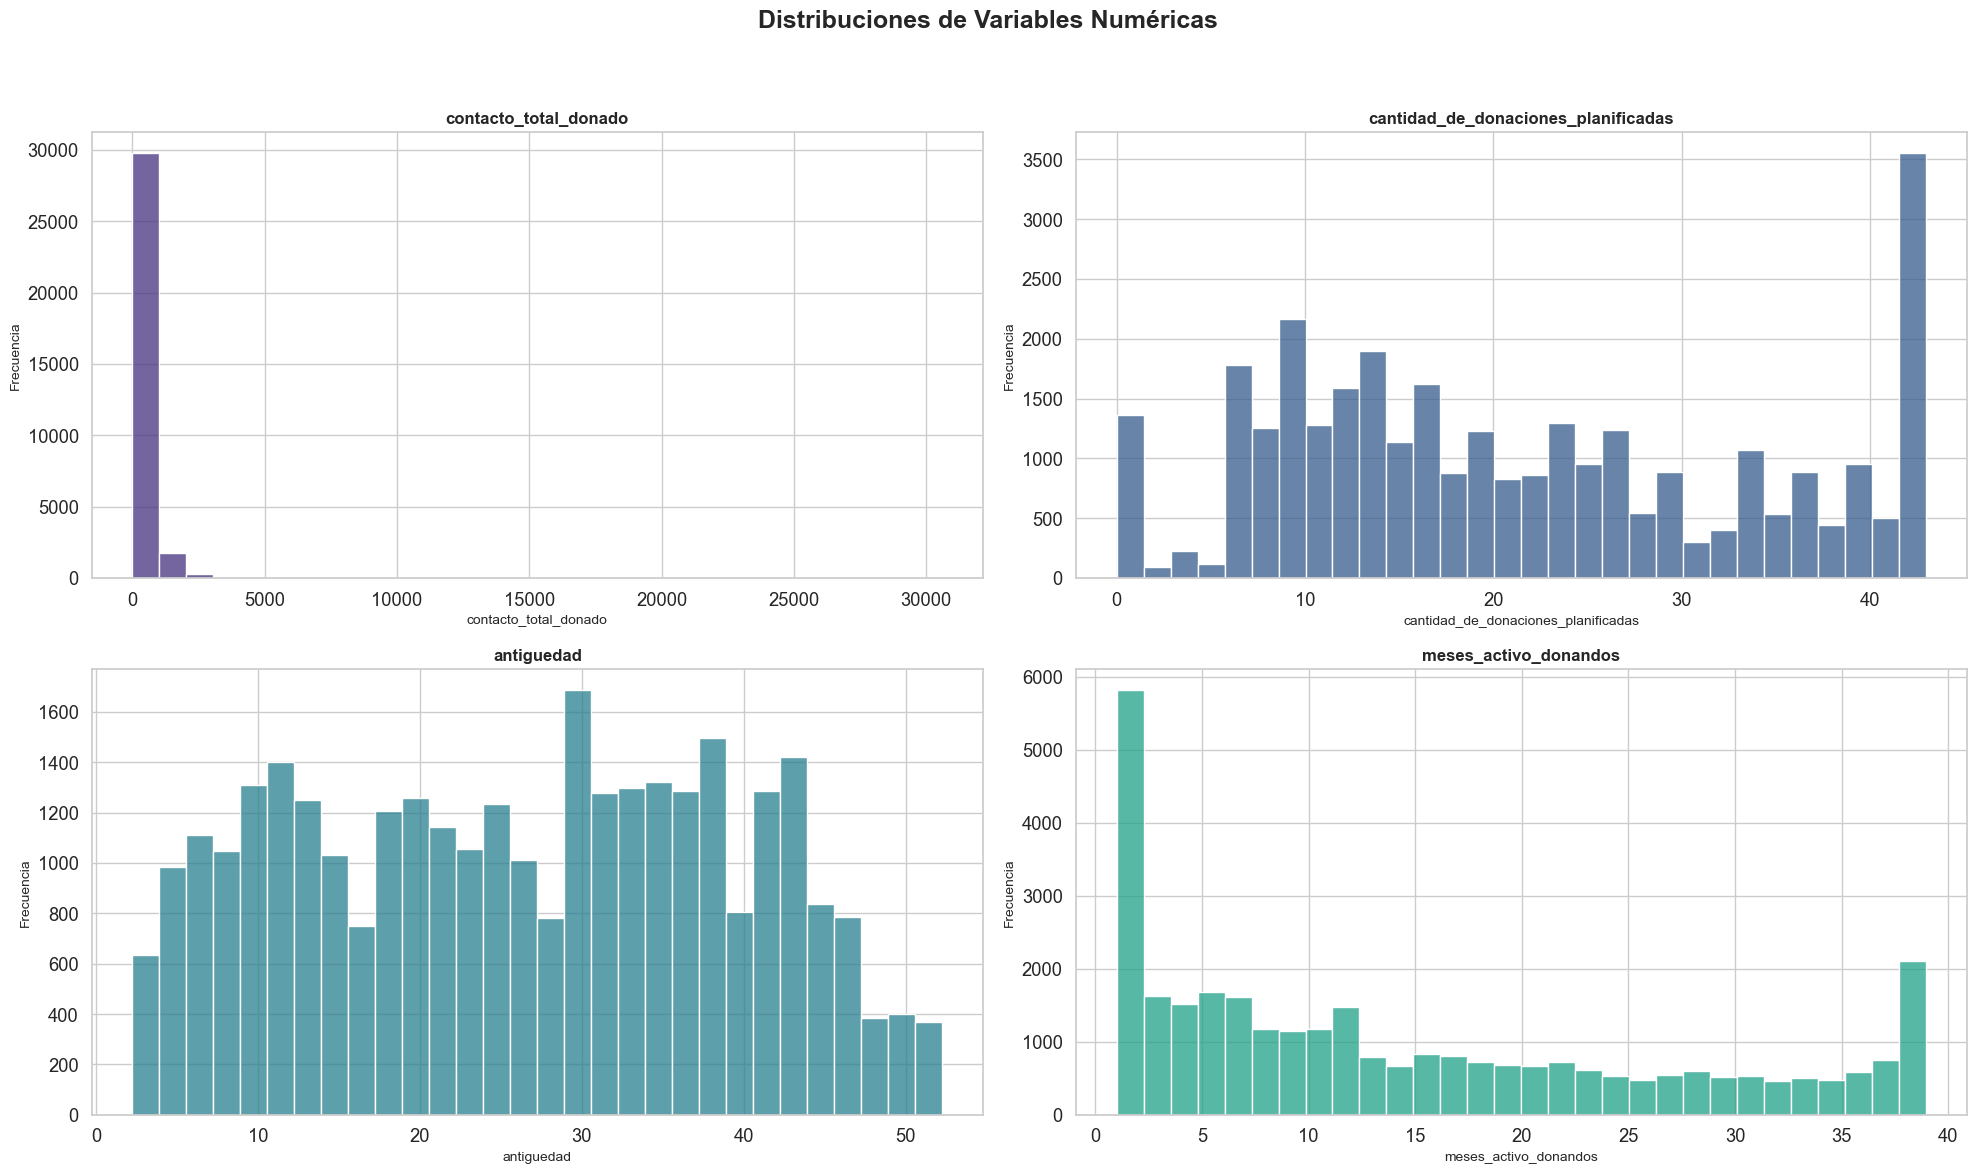

In [863]:
 
sns.set_style("whitegrid")  
sns.set_palette("viridis")   

 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))   
axes = axes.flatten()  

# histogramas para cada variable
for idx, column in enumerate(df_donantes.select_dtypes(include=["float", "int"]).columns[:15]):
    sns.histplot(data=df_donantes, x=column, bins=30, ax=axes[idx], color=sns.color_palette()[idx % 10])
    axes[idx].set_title(f"{column}", fontsize=12, fontweight="bold")
    axes[idx].set_xlabel(column, fontsize=10)
    axes[idx].set_ylabel("Frecuencia", fontsize=10)

# Ajustes finales
plt.suptitle("Distribuciones de Variables Numéricas", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


In [865]:
 
categorical_features = df_donantes.select_dtypes(include=['object', 'category']).columns  # Seleccionar columnas categóricas
print(categorical_features)

Index(['canal_de_la_campana', 'compromiso_de_donacion_tipo_de_registro',
       'contacto_donante_activo', 'estado_del_compromiso',
       'genero_from_contactos', 'medio_de_pago'],
      dtype='object')


In [867]:
def plot_categorical_distributions_with_missing(data, categorical_cols, rows, cols):
    sns.set_style("whitegrid")
    sns.set_palette("viridis")
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 18))
    axes = axes.flatten()
    
    for idx, col in enumerate(categorical_cols):
        if idx < len(axes):
            ax = axes[idx]
            # Calcular conteos y nulos
            value_counts = data[col].value_counts()
            missing_count = data[col].isna().sum()
            plot_data = pd.concat([value_counts, pd.Series({'faltantes': missing_count})])
            
            colors = sns.color_palette("viridis", n_colors=len(plot_data))
            sns.barplot(y=plot_data.index, x=plot_data.values, ax=ax, palette=colors)
            
            ax.set_title(f"{col}", fontsize=12, fontweight="bold")
            ax.set_xlabel("Frecuencia", fontsize=10)
            ax.set_ylabel("", fontsize=10)
            
            for patch in ax.patches:
                count = int(patch.get_width())
                ax.annotate(f'{count}', (patch.get_width() + 0.5, patch.get_y() + patch.get_height() / 2),
                            fontsize=10, color='black', va='center')
    
    for idx in range(len(categorical_cols), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle("Distribuciones de Variables Categóricas con Valores Faltantes", fontsize=16, fontweight="bold")
    plt.show()


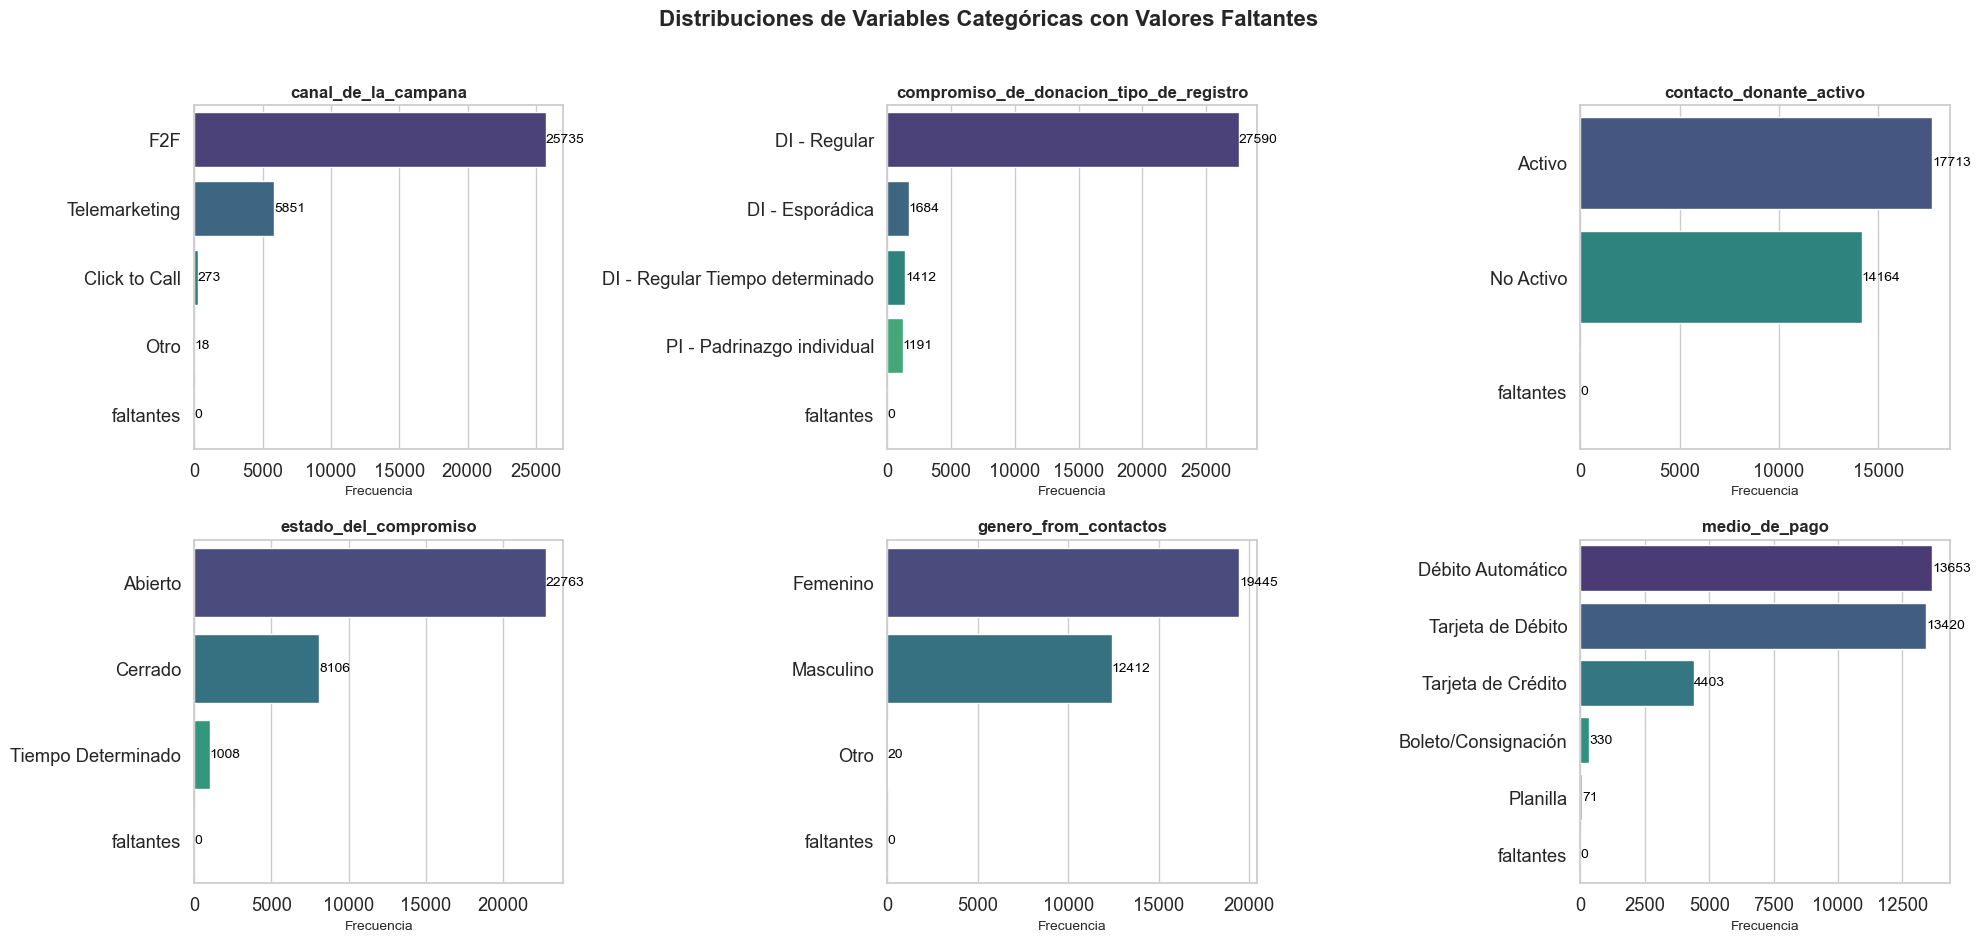

In [869]:

plot_categorical_distributions_with_missing(df_donantes, categorical_features, rows=4, cols=3)


## Preprocesamiento de Datos Categóricos y Numéricos

In [871]:
analyze_columns(df_donantes, sortby="Variable").sort_values(["Type", "Null Percentage"], ascending=False)

Resumen de las 10 columnas procesadas:



,Variable,Unique Values,Null Count,Null Percentage,Type,Random Value
2,antiguedad,1454,0,0.0,Numeric,14.133333
1,cantidad_de_donaciones_planificadas,193,0,0.0,Numeric,19.0
0,contacto_total_donado,691,0,0.0,Numeric,440.0
3,meses_activo_donandos,1202,0,0.0,Numeric,14.766667
4,canal_de_la_campana,4,0,0.0,Categorical,F2F
5,compromiso_de_donacion_tipo_de_registro,4,0,0.0,Categorical,DI - Regular
6,contacto_donante_activo,2,0,0.0,Categorical,Activo
7,estado_del_compromiso,3,0,0.0,Categorical,Tiempo Determinado
8,genero_from_contactos,3,0,0.0,Categorical,Femenino
9,medio_de_pago,5,0,0.0,Categorical,Tarjeta de Débito


In [873]:
#  One-Hot Encoding para las variables categóricas
data_encoded = pd.get_dummies(df_donantes, columns=list(categorical_features), drop_first=True)
data_encoded.shape

(31877, 19)

In [168]:
# Escalamos las variables numéricas y One-Hot Encoded
scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data_encoded),
    columns=data_encoded.columns
)

 

In [877]:
data_scaled.head(2)


,contacto_total_donado,cantidad_de_donaciones_planificadas,antiguedad,meses_activo_donandos,canal_de_la_campana_F2F,canal_de_la_campana_Otro,canal_de_la_campana_Telemarketing,compromiso_de_donacion_tipo_de_registro_DI - Regular,compromiso_de_donacion_tipo_de_registro_DI - Regular Tiempo determinado,compromiso_de_donacion_tipo_de_registro_PI - Padrinazgo individual,contacto_donante_activo_No Activo,estado_del_compromiso_Cerrado,estado_del_compromiso_Tiempo Determinado,genero_from_contactos_Masculino,genero_from_contactos_Otro,medio_de_pago_Débito Automático,medio_de_pago_Planilla,medio_de_pago_Tarjeta de Crédito,medio_de_pago_Tarjeta de Débito
0,-0.567110,1.699332,1.856407,-0.296333,-2.046950,-0.02377,2.109059,0.394186,-0.215286,-0.197009,1.118287,-0.583955,-0.180705,-0.798534,-0.025056,-0.865550,-0.047247,-0.400326,1.172747
1,-0.527591,-0.762699,0.634038,-0.967308,0.488532,-0.02377,-0.474145,0.394186,-0.215286,-0.197009,1.118287,1.712460,-0.180705,-0.798534,-0.025056,1.155335,-0.047247,-0.400326,-0.852699


## Análisis Comparativo de Clustering

In [850]:
def plot_3d_clusters(data, feature_cols, col_cluster, cmap, model, n_clusters):
    cmap_instance = plt.get_cmap(cmap)
    unique_clusters = sorted(data[col_cluster].unique())
    legend_handles = [mlines.Line2D([], [], marker='o', linestyle='None', markersize=8,
                                    markerfacecolor=cmap_instance(float(cl)/(n_clusters-1) if n_clusters>1 else 0),
                                    label=f'Cluster {cl}') for cl in unique_clusters]
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(data[feature_cols[0]], data[feature_cols[1]], data[feature_cols[2]],
                    c=data[col_cluster], cmap=cmap, s=50, alpha=0.7)
    ax.set_title(f'{model} Clustering 3D (n_clusters={n_clusters})', fontsize=16, pad=20)
    ax.set_xlabel(feature_cols[0], fontsize=12, labelpad=15)
    ax.set_ylabel(feature_cols[1], fontsize=12, labelpad=15)
    ax.set_zlabel(feature_cols[2], fontsize=12, labelpad=15)
    ax.tick_params(axis='x', labelsize=10, pad=5)
    ax.tick_params(axis='y', labelsize=10, pad=5)
    ax.tick_params(axis='z', labelsize=10, pad=5)
    ax.legend(handles=legend_handles, title='Clusters', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, title_fontsize=12)
    ax.set_box_aspect([1.5, 1.2, 1])
    plt.tight_layout()
    plt.show()


def check_result(data, col_cluster, plot=False):
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        sns.countplot(data=data, x=col_cluster, palette="viridis", ax=ax[0])
        ax[0].set_ylabel('Count', fontsize=14)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
        for p in ax[0].patches:
            ax[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2, p.get_height()),
                           ha='center', va='bottom', fontsize=12, color='black')
        slices = data[col_cluster].value_counts().sort_index().values
        activities = data[col_cluster].value_counts().sort_index().index.tolist()
        ax[1].pie(slices, labels=activities, colors=sns.color_palette('viridis'), autopct='%1.1f%%')
        ax[1].set_title("Percentage", fontsize=14)
        fig.suptitle('Count of Each Cluster', fontsize=14)
        plt.tight_layout()
        plt.show()



def plot_metrics(metrics_dict, model_name):
    """Visualización unificada de métricas (Silhouette y Calinski-Harabasz) para cualquier modelo"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    ax[0].plot(metrics_dict['k_range'], metrics_dict['silhouette'], 'ro-')
    ax[0].set_title(f'Silhouette Score - {model_name}')
    
    ax[1].plot(metrics_dict['k_range'], metrics_dict['calinski'], 'go-')
    ax[1].set_title(f'Calinski-Harabasz - {model_name}')
    
    plt.tight_layout()
    plt.show()
 

def train_clustering_model(model_func, param_range, model_name, data, use_predict=False, **kwargs):
    """
    Función genérica para entrenar modelos de clustering
    Si use_predict es True, se utiliza model.fit(data) seguido de model.predict(data); de lo contrario, model.fit_predict(data).
    """
    metrics = {'silhouette': [], 'calinski': [], 'k_range': list(param_range)}
    for k in tqdm(param_range, desc=f"Entrenando {model_name}"):
        model = model_func(k, **kwargs)
        if use_predict:
            model.fit(data)
            labels = model.predict(data)
        else:
            labels = model.fit_predict(data)
        metrics['silhouette'].append(silhouette_score(data, labels))
        metrics['calinski'].append(calinski_harabasz_score(data, labels))
    plot_metrics(metrics, model_name)
    return metrics


def add_clusters_to_data(data, labels, cluster_name):
    return pd.concat([data, pd.Series(labels, name=cluster_name)], axis=1)

 
def plot_gmm_bic(bic_df):
    if 'n_components' not in bic_df.columns:
        bic_df = bic_df.rename(columns={'k':'n_components','cov_type':'covariance_type','bic':'BIC_score'})
    bic_df["n_components"] = pd.to_numeric(bic_df["n_components"], errors='coerce').astype(int)
    bic_df["BIC_score"] = pd.to_numeric(bic_df["BIC_score"], errors='coerce').astype(float)
    FIG_SIZE = (15, 8)
    sns.set_theme(style="whitegrid", font_scale=1.2)
    g = sns.catplot(data=bic_df, kind="bar", x="n_components", y="BIC_score", hue="covariance_type", palette="viridis", ci="sd", aspect=1.5, height=6, legend_out=False)
    g.fig.set_size_inches(FIG_SIZE)
    if g._legend is not None: g._legend.remove()
    ax = g.ax if hasattr(g, "ax") else g.axes.flatten()[0]
    handles, labels = ax.get_legend_handles_labels()
    g.fig.legend(handles, labels, title="Covariance Type", loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=len(labels))
    g.set_axis_labels("Number of Components", "BIC Score")
    g.fig.suptitle("Optimal Number of Components for GMM", fontsize=18, fontweight="bold")
    g.fig.subplots_adjust(top=0.88, bottom=0.15)
    for ax in g.axes.flat:
        for p in ax.patches:
            height_value = p.get_height()
            ax.annotate(f'{height_value:.0f}', (p.get_x()+p.get_width()/2, height_value), ha='center', va='bottom', fontsize=10, color='black', xytext=(0,5), textcoords='offset points')
    plt.show()


In [852]:
def main_clustering_workflow(data_scaled, krange):


    print("=== Ejecutando Modelo: KMeans ===")
    print(f"k_range: {list(krange)} | Hiperparámetros: {KMEANS_PARAMS}")
    start_time = time.time()
    kmeans_metrics = train_clustering_model(lambda k: KMeans(n_clusters=k, **KMEANS_PARAMS), krange, 'KMeans', data_scaled)
    elapsed_time = time.time() - start_time
    print(f"Tiempo de ejecución KMeans: {elapsed_time:.2f} segundos.")


    
    print("\n=== Ejecutando Modelo: MiniBatch KMeans ===")
    print(f"k_range: {list(krange)} | Hiperparámetros: {MINIBATCH_PARAMS}")
    start_time = time.time()
    minibatch_metrics = train_clustering_model(lambda k: MiniBatchKMeans(n_clusters=k, **MINIBATCH_PARAMS), krange, 'MiniBatch KMeans', data_scaled)
    elapsed_time = time.time() - start_time
    print(f"Tiempo de ejecución MiniBatch KMeans: {elapsed_time:.2f} segundos.")

    
    
    print("\n=== Ejecutando Modelo: Clustering Jerárquico (Agglomerative) ===")
    print(f"Se utiliza PCA (n_components={PCA_COMPONENTS}) y se samplea el {int(SAMPLE_FRACTION*100)}% de los datos para reducir la carga computacional.")
    data_pca_sampled = pd.DataFrame(PCA(n_components=PCA_COMPONENTS, random_state=42).fit_transform(data_scaled)).sample(frac=SAMPLE_FRACTION, random_state=42)
    print("Dimensiones de la muestra:", data_pca_sampled.shape)
    start_time = time.time()
    hierarchical_metrics = train_clustering_model(lambda k: AgglomerativeClustering(n_clusters=k), krange, 'Hierarchical', data_pca_sampled)
    elapsed_time = time.time() - start_time
    print(f"Tiempo de ejecución Hierarchical: {elapsed_time:.2f} segundos.")


    
    print("\n=== Ejecutando Modelo: Birch ===")
    print(f"k_range: {list(krange)} | Hiperparámetros: threshold={BIRCH_THRESHOLD}, branching_factor={BRANCHING_FACTOR}")
    start_time = time.time()
    birch_metrics = train_clustering_model(lambda k: Birch(n_clusters=k, threshold=BIRCH_THRESHOLD, branching_factor=BRANCHING_FACTOR), krange, 'Hierarchical (Birch)', data_scaled)
    elapsed_time = time.time() - start_time
    print(f"Tiempo de ejecución Birch: {elapsed_time:.2f} segundos.")


   
    print("\n=== Ejecutando Modelo: Gaussian Mixture Models (GMM) ===")
    gmm_params = {'covariance_types': GMM_COV_TYPES, 'k_range': krange}
    print(f"k_range: {list(gmm_params['k_range'])} | Covariance Types: {gmm_params['covariance_types']}")
    start_time = time.time()
    bic_scores = []
    for cov_type in tqdm(gmm_params['covariance_types'], desc="GMM Covariance Types"):
        for k in gmm_params['k_range']:
            gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
            gmm.fit(data_scaled)
            bic_scores.append({'k': k, 'cov_type': cov_type, 'bic': gmm.bic(data_scaled)})
    bic_df = pd.DataFrame(bic_scores)
    plot_gmm_bic(bic_df)
    best_cov_type = bic_df.loc[bic_df['bic'].idxmin(), 'cov_type']
    print("Best covariance type:", best_cov_type)
    # Ahora, reentrenar GMM solo con covariance_type y evaluar Silhouette y Calinski-Harabasz
    gmm_metrics = train_clustering_model(
        lambda k, covariance_type: GaussianMixture(n_components=k, covariance_type=covariance_type, random_state=42),
        krange,
        f'GMM {best_cov_type}',
        data_scaled,
        use_predict=True,
        covariance_type=best_cov_type
    )
 
    elapsed_time = time.time() - start_time
    print(f"Tiempo de evaluación final GMM: {elapsed_time:.2f} segundos.")

    
    print("\n=== Ejecutando DBSCAN Grid Search ===")
    print("Hiperparámetros: eps_values y min_samples_range")
    start_time = time.time()
    eps_values = np.arange(DBSCAN_EPS_START, DBSCAN_EPS_END, DBSCAN_EPS_STEP)
    min_samples_range = np.arange(DBSCAN_MIN_SAMPLES_START, DBSCAN_MIN_SAMPLES_END, DBSCAN_MIN_SAMPLES_STEP)
    def dbscan_grid_search(eps_values, min_samples):
        results = []
        for eps, min_s in tqdm(product(eps_values, min_samples), total=len(eps_values)*len(min_samples)):
            dbscan = DBSCAN(eps=eps, min_samples=min_s)
            labels = dbscan.fit_predict(data_scaled)
            if len(np.unique(labels)) > 1:
                results.append({'eps': eps, 'min_samples': min_s, 'silhouette': silhouette_score(data_scaled, labels), 'n_clusters': len(np.unique(labels))})
        return pd.DataFrame(results)
    dbscan_results = dbscan_grid_search(eps_values, min_samples_range)
    sns.heatmap(pd.pivot_table(dbscan_results, values='silhouette', index='min_samples', columns='eps'))
    plt.show()
    elapsed_time = time.time() - start_time
    print(f"Tiempo de ejecución DBSCAN Grid Search: {elapsed_time:.2f} segundos.")




In [ ]:
# VARIABLES GLOBALES
KMEANS_PARAMS = {'init': 'k-means++', 'n_init': 10}
MINIBATCH_PARAMS = {'init': 'k-means++', 'batch_size': 100, 'n_init': 10}
PCA_COMPONENTS   = 0.95
SAMPLE_FRACTION  = 0.5
BIRCH_THRESHOLD  = 0.5
BRANCHING_FACTOR = 50
GMM_COV_TYPES = ['spherical', 'tied', 'diag', 'full']

DBSCAN_EPS_START = 6.5
DBSCAN_EPS_END = 7.5
DBSCAN_EPS_STEP = 0.5
DBSCAN_MIN_SAMPLES_START = 20
DBSCAN_MIN_SAMPLES_END = 31
DBSCAN_MIN_SAMPLES_STEP = 2

krange       = range(2, 12)

=== Ejecutando Modelo: KMeans ===
k_range: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] | Hiperparámetros: {'init': 'k-means++', 'n_init': 10}


Entrenando KMeans: 100%|████████████████████████| 10/10 [01:22<00:00,  8.23s/it]


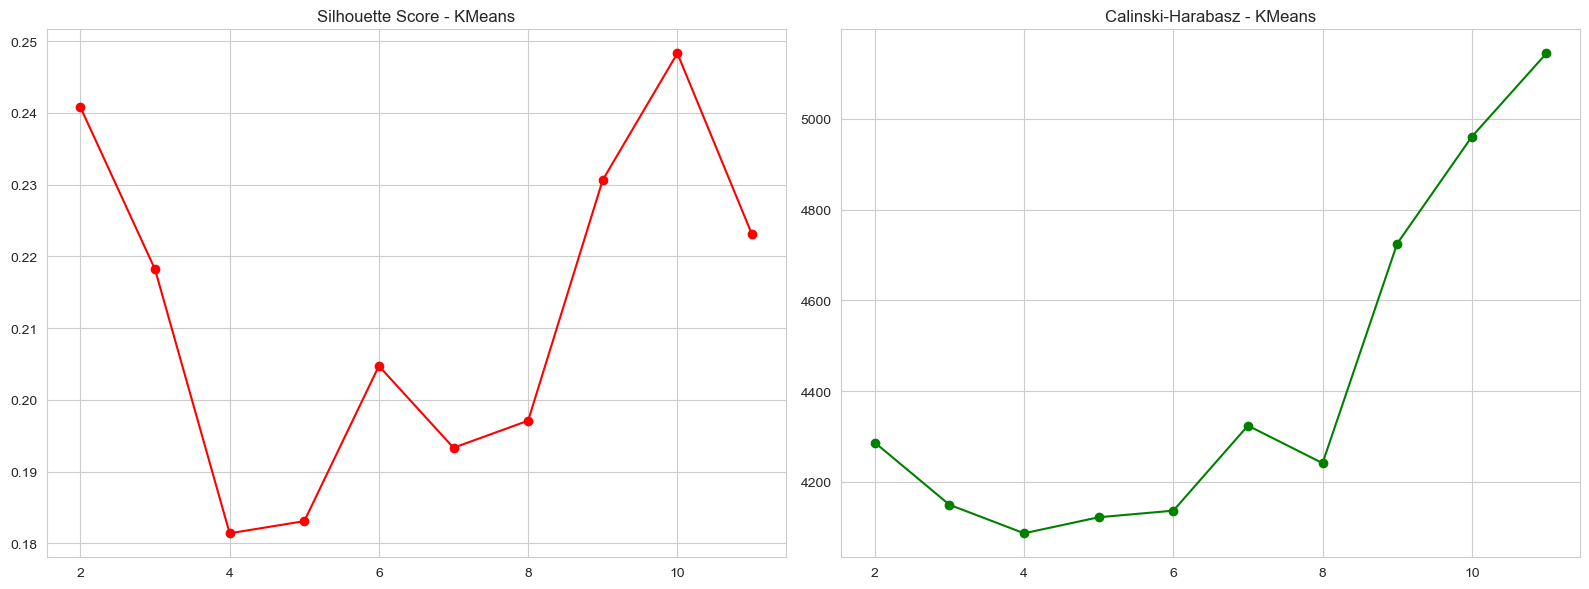

Tiempo de ejecución KMeans: 82.54 segundos.

=== Ejecutando Modelo: MiniBatch KMeans ===
k_range: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] | Hiperparámetros: {'init': 'k-means++', 'batch_size': 100, 'n_init': 10}


Entrenando MiniBatch KMeans: 100%|██████████████| 10/10 [01:06<00:00,  6.64s/it]


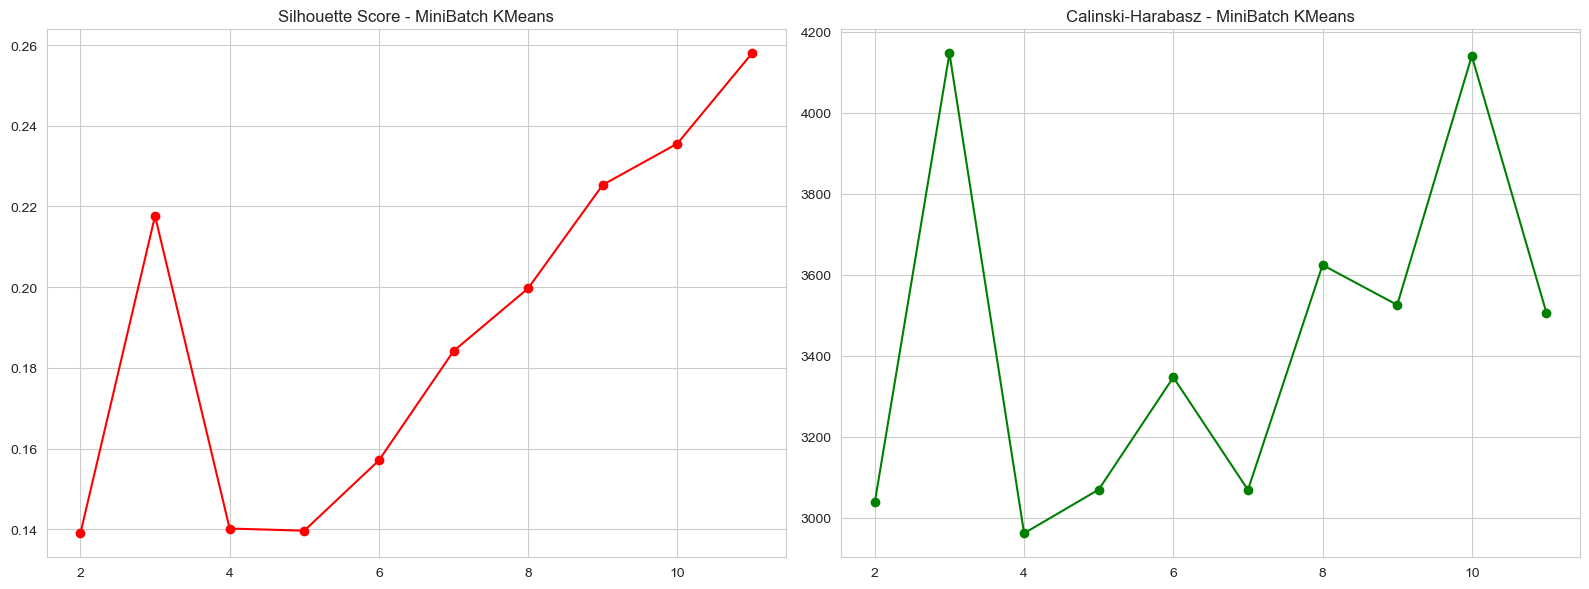

Tiempo de ejecución MiniBatch KMeans: 66.50 segundos.

=== Ejecutando Modelo: Clustering Jerárquico (Agglomerative) ===
Se utiliza PCA (n_components=0.95) y se samplea el 50% de los datos para reducir la carga computacional.
Dimensiones de la muestra: (15938, 13)


Entrenando Hierarchical: 100%|██████████████████| 10/10 [00:52<00:00,  5.26s/it]


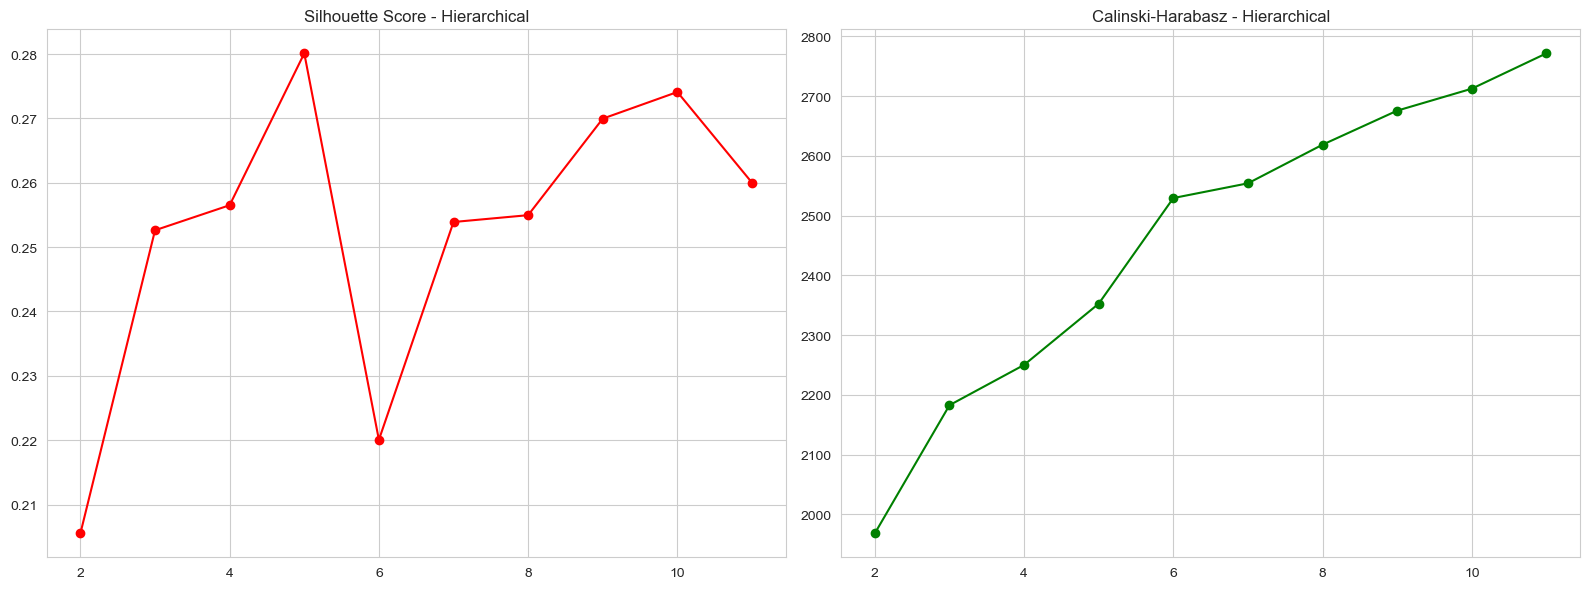

Tiempo de ejecución Hierarchical: 52.74 segundos.

=== Ejecutando Modelo: Birch ===
k_range: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] | Hiperparámetros: threshold=0.5, branching_factor=50


Entrenando Hierarchical (Birch): 100%|██████████| 10/10 [01:24<00:00,  8.47s/it]


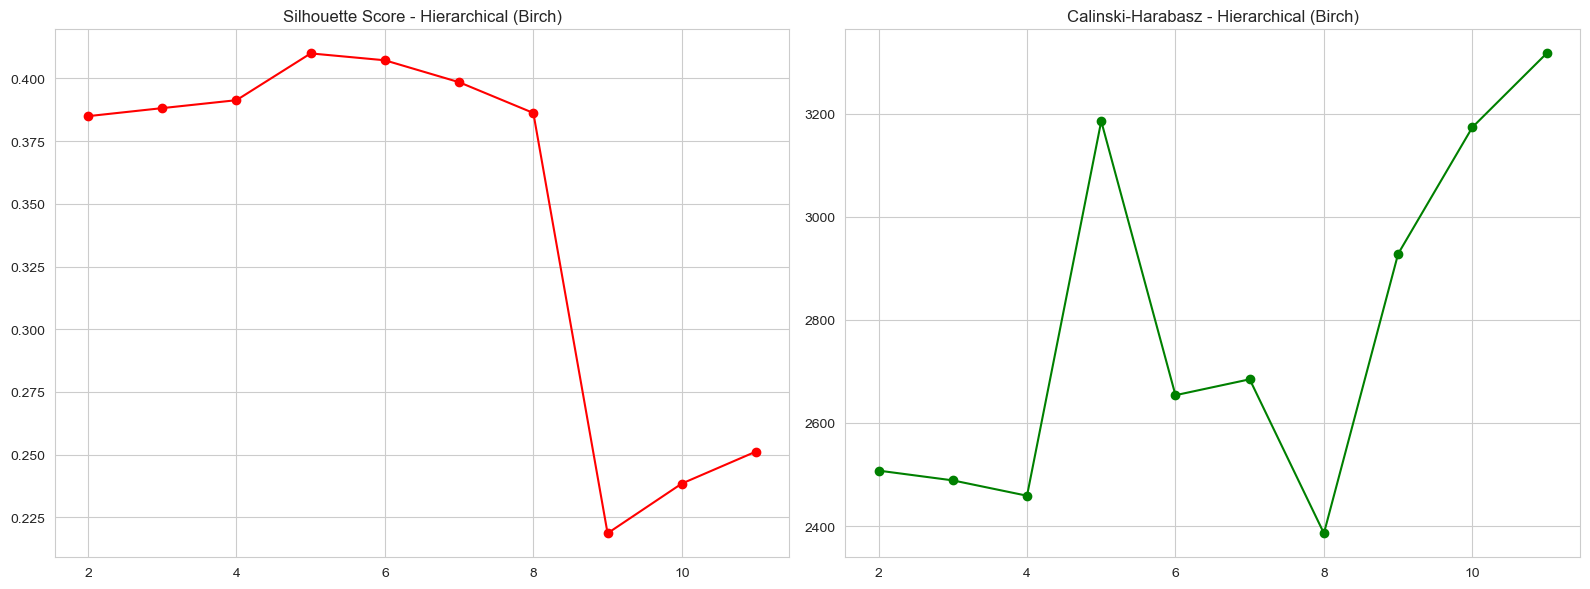

Tiempo de ejecución Birch: 84.88 segundos.

=== Ejecutando Modelo: Gaussian Mixture Models (GMM) ===
k_range: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] | Covariance Types: ['spherical', 'tied', 'diag', 'full']


GMM Covariance Types: 100%|███████████████████████| 4/4 [00:18<00:00,  4.74s/it]


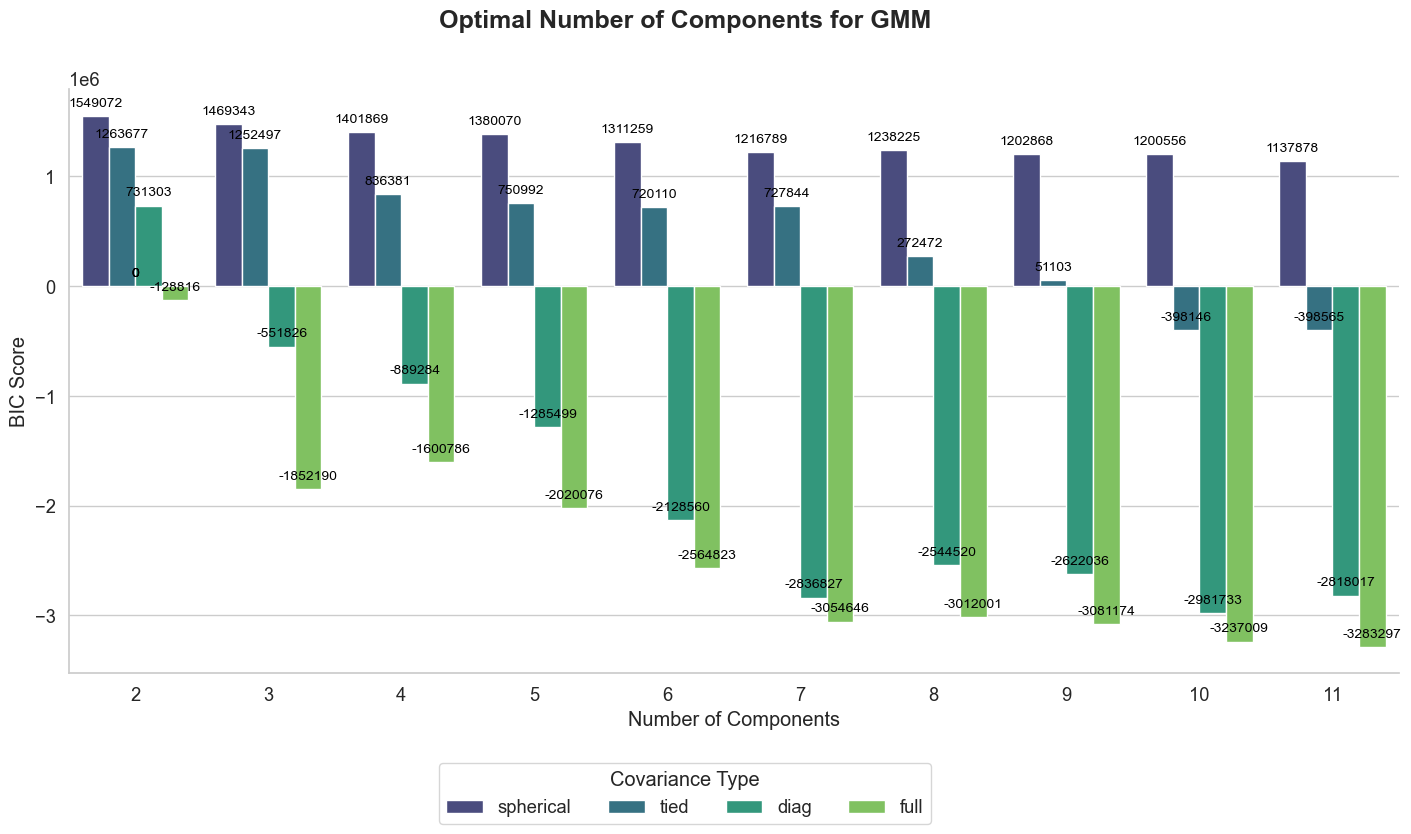

Best covariance type: full


Entrenando GMM full: 100%|██████████████████████| 10/10 [01:27<00:00,  8.73s/it]


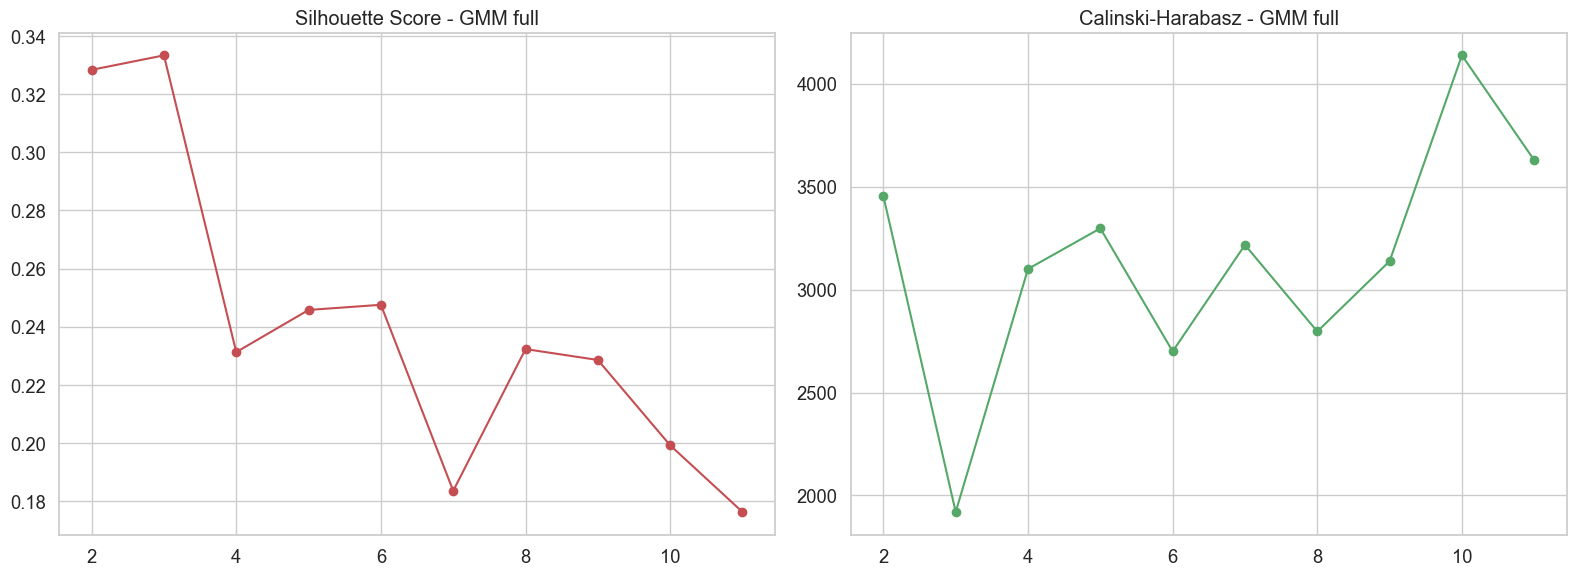

Tiempo de evaluación final GMM: 106.77 segundos.

=== Ejecutando DBSCAN Grid Search ===
Hiperparámetros: eps_values y min_samples_range


100%|███████████████████████████████████████████| 12/12 [14:36<00:00, 73.04s/it]


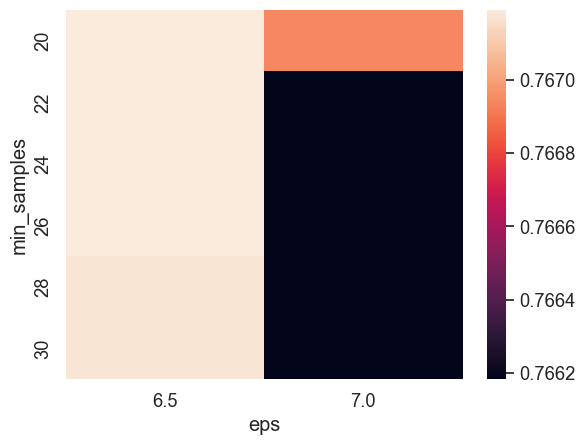

Tiempo de ejecución DBSCAN Grid Search: 876.79 segundos.


In [138]:

## Ejecutamos diversas configuraciones
main_clustering_workflow(data_scaled, krange)


## Selección del Modelo Óptimo de Clustering

In [885]:
print("\n--- IMPUTACIÓN MANUAL DE PARÁMETROS ---")

params = {
    'kmeans_k': 4, #kmeans
    'minibatch_k': 3, #minibatach kmeans
    'hierarchical_k': 5, #hierarchical model
    'birch_k': 4, #birch
    'gmm_cov': 'full',  'gmm_k': 3,  #gmm
    'dbscan_eps': 6.5, 'dbscan_min_samples': 20 #dbscan
}

final_models = {
    'KMeans': KMeans(n_clusters=params['kmeans_k']),
    'MiniBatchKMeans': MiniBatchKMeans(n_clusters=params['minibatch_k']),
    'Hierarchical': AgglomerativeClustering(n_clusters=params['hierarchical_k']),
    'BIRCH': Birch(n_clusters= params['birch_k'] , threshold=BIRCH_THRESHOLD, branching_factor=BRANCHING_FACTOR),
    'GMM': GaussianMixture(n_components=params['gmm_k'], covariance_type=params['gmm_cov']),
    'DBSCAN': DBSCAN(eps=params['dbscan_eps'], min_samples=params['dbscan_min_samples']),
}

results = {}

DATA_PCA_SAMPLED = pd.DataFrame(PCA(n_components=PCA_COMPONENTS, random_state=42).fit_transform(data_scaled)).sample(frac=SAMPLE_FRACTION, random_state=42)
print(f"Para el modelo Hierachical, se utiliza PCA (n_components={PCA_COMPONENTS}) y se samplea el {int(SAMPLE_FRACTION*100)}% de los datos para reducir la carga computacional.")
print(DATA_PCA_SAMPLED.shape)

print("\n--- INICIANDO ENTRENAMIENTO DE MODELOS ---")
for name, model in tqdm(final_models.items(), desc=f"Ejecutando Modelos de Clustering", unit="modelo"):
    print(f"\nEjecutando {name}...")
    start_time = time.time()
    data_input = DATA_PCA_SAMPLED if name =="Hierarchical" else data_scaled
    model.fit(data_input)
    labels = model.labels_ if hasattr(model, 'labels_') else model.predict(data_input)
    exec_time = time.time() - start_time
    results[name] = {
        'silhouette': silhouette_score(data_input, labels),
        'calinski': calinski_harabasz_score(data_input, labels),
        'clusters': len(np.unique(labels)),
        'execution_time': exec_time
    }
    
    print(f"El modelo {name} tomó {exec_time:.2f} segundos en ser evaluado.")
 
    if name=="Hierarchical":
        DATA_PCA_SAMPLED[f'cluster_{name.lower()}'] = labels
    else: 
         df_donantes[f'cluster_{name.lower()}'] = labels
  
    
    

print("\n--- PROCESO COMPLETADO ---")





--- IMPUTACIÓN MANUAL DE PARÁMETROS ---
Para el modelo Hierachical, se utiliza PCA (n_components=0.95) y se samplea el 50% de los datos para reducir la carga computacional.
(15938, 13)

--- INICIANDO ENTRENAMIENTO DE MODELOS ---


Ejecutando Modelos de Clustering:   0%|               | 0/6 [00:00<?, ?modelo/s]


Ejecutando KMeans...


Ejecutando Modelos de Clustering:  17%|█▏     | 1/6 [00:07<00:39,  8.00s/modelo]

El modelo KMeans tomó 0.12 segundos en ser evaluado.

Ejecutando MiniBatchKMeans...


Ejecutando Modelos de Clustering:  33%|██▎    | 2/6 [00:16<00:32,  8.17s/modelo]

El modelo MiniBatchKMeans tomó 0.05 segundos en ser evaluado.

Ejecutando Hierarchical...


Ejecutando Modelos de Clustering:  50%|███▌   | 3/6 [00:23<00:22,  7.52s/modelo]

El modelo Hierarchical tomó 4.83 segundos en ser evaluado.

Ejecutando BIRCH...


Ejecutando Modelos de Clustering:  67%|████▋  | 4/6 [00:33<00:17,  8.51s/modelo]

El modelo BIRCH tomó 0.73 segundos en ser evaluado.

Ejecutando GMM...


Ejecutando Modelos de Clustering:  83%|█████▊ | 5/6 [00:44<00:09,  9.48s/modelo]

El modelo GMM tomó 0.30 segundos en ser evaluado.

Ejecutando DBSCAN...


Ejecutando Modelos de Clustering: 100%|███████| 6/6 [04:27<00:00, 44.59s/modelo]

El modelo DBSCAN tomó 214.40 segundos en ser evaluado.

--- PROCESO COMPLETADO ---


In [887]:

best_models = pd.DataFrame(results).T.sort_values(["silhouette", "calinski"])

print("\n--- MÉTRICAS FINALES ---")
best_models



--- MÉTRICAS FINALES ---


,silhouette,calinski,clusters,execution_time
MiniBatchKMeans,0.136332,2898.753019,3.0,0.052869
KMeans,0.144688,3329.881683,4.0,0.121295
Hierarchical,0.280115,2352.558939,5.0,4.829788
GMM,0.328680,1947.664787,3.0,0.299857
BIRCH,0.391313,2458.731452,4.0,0.728084
DBSCAN,0.767191,1526.041875,3.0,214.397006


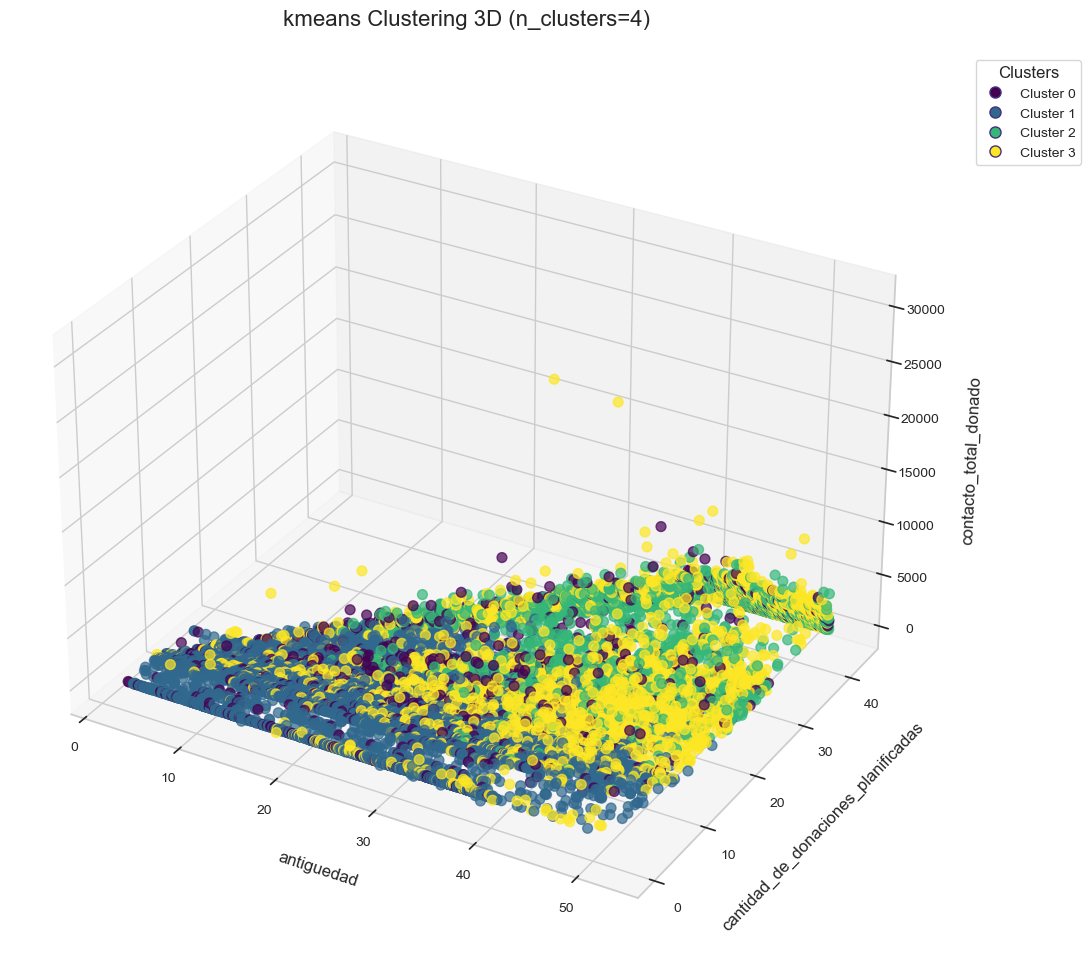

In [889]:
features = [  "antiguedad", "cantidad_de_donaciones_planificadas", "contacto_total_donado", ]

plot_3d_clusters(df_donantes, features, 'cluster_kmeans','viridis' ,'kmeans', 4)
 

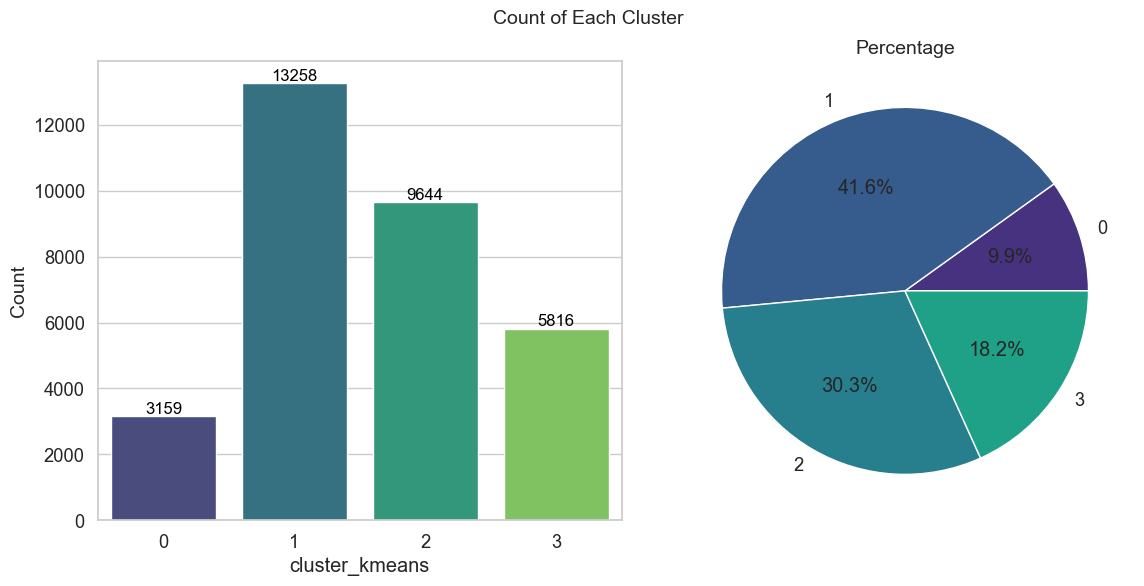

In [891]:
check_result(df_donantes, "cluster_kmeans", plot=True)

## Analisis del mejor modelo de clustering

In [893]:
cluster_summary = df_donantes.groupby('cluster_kmeans').agg({
    "contacto_total_donado": ["mean", "std"],
    "antiguedad": ["mean", "std"],
    "meses_activo_donandos": ["mean", "std"]
}).reset_index().round(2)

print("Resumen descriptivo por Cluster:")
print(cluster_summary.to_string(index=False))


Resumen descriptivo por Cluster:
cluster_kmeans contacto_total_donado        antiguedad       meses_activo_donandos      
                                mean    std       mean   std                  mean   std
             0                377.48 482.60      26.52 12.09                 14.46 11.48
             1                116.32 137.83      17.24 11.16                  5.82  4.85
             2                420.30 409.33      33.02  8.66                 22.80 10.79
             3                625.16 866.28      34.21 11.63                 22.11 13.04


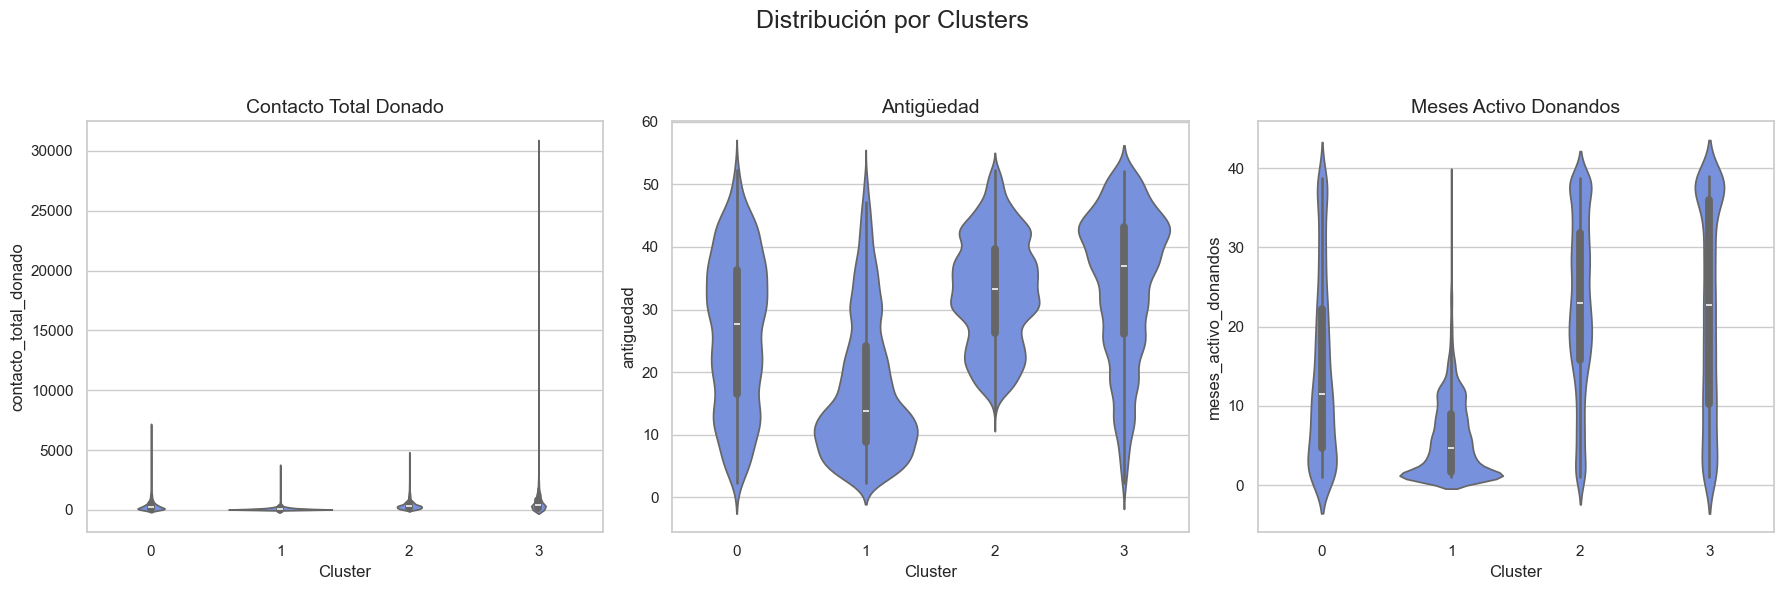

In [903]:
metrics = {
    "contacto_total_donado": "Total Donado", "Soles"
    "antiguedad": "Antigüedad", "Meses"
    "meses_activo_donandos": "Meses Activo Donandos" , "Meses"
}

sns.set_theme(style="whitegrid", palette="coolwarm")
fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 6))

 
axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

for ax, (col, title) in zip(axes, metrics.items()):
    sns.violinplot(data=df_donantes, x='cluster_kmeans', y=col, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Cluster")
    ax.set_xlabel(metrics)

fig.suptitle("Distribución por Clusters", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [907]:
donation_75 = df_donantes["contacto_total_donado"].quantile(0.75)
donation_25 = df_donantes["contacto_total_donado"].quantile(0.25)

frequency_75 = df_donantes["cantidad_de_donaciones_planificadas"].quantile(0.75)
frequency_25 = df_donantes["cantidad_de_donaciones_planificadas"].quantile(0.25)

tenure_75 = df_donantes["antiguedad"].quantile(0.75)
tenure_25 = df_donantes["antiguedad"].quantile(0.25)

cluster_means      = df_donantes.groupby("cluster_kmeans")["contacto_total_donado"].mean()


high_value_cluster = cluster_means.idxmax()
risk_cluster       = cluster_means.idxmin()



print("Promedio de Donación por Cluster (k-means):")
print(cluster_means.round(2).to_string(), "\n")

print("Cluster con mayor valor de donación:", high_value_cluster)
print("Cluster con menor valor de donación:", risk_cluster)

Promedio de Donación por Cluster (k-means):
cluster_kmeans
0    377.48
1    116.32
2    420.30
3    625.16 

Cluster con mayor valor de donación: 3
Cluster con menor valor de donación: 1


In [909]:
conditions = [
    
    (df_donantes["cluster_kmeans"] == high_value_cluster) & 
    (df_donantes["contacto_total_donado"] >= donation_75) & 
    (df_donantes["cantidad_de_donaciones_planificadas"] >= frequency_75),
    
    (df_donantes["cluster_kmeans"] == risk_cluster) & 
    (df_donantes["contacto_total_donado"] <= donation_25) & 
    (df_donantes["cantidad_de_donaciones_planificadas"] <= frequency_25),
    
    (df_donantes["contacto_total_donado"] < donation_75) &
    (df_donantes["contacto_total_donado"] > donation_25) & 
    (df_donantes["cantidad_de_donaciones_planificadas"] <= frequency_25)
    
]


choices = ["donante_alto_valor", "donante_en_riesgo", "donante_potencial_de_mejora"]

df_donantes["categoria"] = np.select(conditions, choices, default="donante_estable")


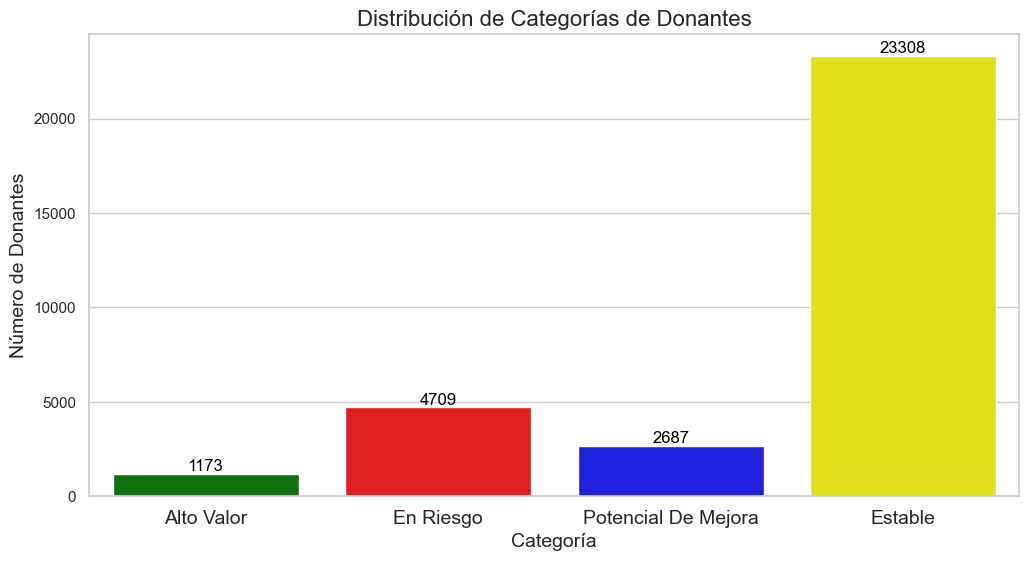

In [913]:
plt.figure(figsize=(12,6))
ax = sns.countplot(
    x="categoria",
    data=df_donantes,
    order=["donante_alto_valor", "donante_en_riesgo", 
           "donante_potencial_de_mejora", "donante_estable"],
    palette=["green", "red", "blue", "yellow"]
)

# Extraer las etiquetas actuales, remover la primera palabra y aplicar formato
current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [' '.join(label.split('_')[1:]).title() for label in current_labels]
ax.set_xticklabels(new_labels, fontsize=14)

ax.set_title("Distribución de Categorías de Donantes", fontsize=16)
ax.set_xlabel("Categoría", fontsize=14)
ax.set_ylabel("Número de Donantes", fontsize=14)

# Anotar cada barra con su valor
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')
plt.show()


## Propuesta de Mejoras por Segmentos y Análisis de Costo-Beneficio

In [946]:
## recuperamos informacion de los donantes (sexo, nombres, etc)
df_donantes["contacto_id_completo"] = contacto_id_completo
df_donantes_makting = pd.merge(df_donantes, data_contactos, how ='left', left_on = 'contacto_id_completo', right_on = 'Id Completo')


In [948]:

df_summary = df_donantes_makting.groupby("categoria").agg(
    total_donado=('contacto_total_donado', 'sum'),
    cantidad=('contacto_total_donado', 'count')
).reset_index()

print("Resumen de donaciones por categoría:")
print(df_summary)

# Definir supuestos de incremento en donación (%) por segmento y escenario
incrementos = {
    'donante_estable': {
        'Optimista': 0.10,
        'Moderado': 0.05,
        'Pesimista': 0.02
    },
    'donante_en_riesgo': {
        'Optimista': 0.15,
        'Moderado': 0.07,
        'Pesimista': 0.03
    },
    'donante_potencial_de_mejora': {
        'Optimista': 0.20,
        'Moderado': 0.10,
        'Pesimista': 0.05
    },
    'donante_alto_valor': {
        'Optimista': 0.08,
        'Moderado': 0.04,
        'Pesimista': 0.02
    }
}

# Supuestos de costos de campaña por categoría (costo promedio por donante)
costos_por_donante = {
    'donante_estable': 2.0,           
    'donante_en_riesgo': 5.0,
    'donante_potencial_de_mejora': 4.0,
    'donante_alto_valor': 8.0
}

# Inicializar lista para almacenar resultados
resultados = []

# Calcular ingreso adicional potencial, costo total de campaña, ROI y el ingreso adicional relativo
for idx, row in df_summary.iterrows():
    categoria = row["categoria"]
    total_actual = row["total_donado"]
    cantidad = row["cantidad"]
    
    if categoria in incrementos and categoria in costos_por_donante:
        # Costo total de campaña: costo por donante * cantidad de donantes en el segmento
        costo_total = costos_por_donante[categoria] * cantidad
        
        for escenario, tasa in incrementos[categoria].items():
            ingreso_adicional = total_actual * tasa
            roi = (ingreso_adicional - costo_total) / costo_total  # ROI
            # Métrica relativa: ingreso adicional potencial por donante
            ingreso_adicional_relativo = ingreso_adicional / cantidad
            resultados.append({
                "Categoria": categoria,
                "Escenario": escenario,
                "Total Donado Actual": total_actual,
                "Cantidad de Donantes": cantidad,
                "Incremento (%)": tasa * 100,
                "Ingreso Adicional Potencial": ingreso_adicional,
                "Costo Total Campaña": costo_total,
                "ROI": roi,
                "Ingreso Adicional Por Donante": ingreso_adicional_relativo
            })


Resumen de donaciones por categoría:
                     categoria  total_donado  cantidad
0           donante_alto_valor    1373471.00      1173
1            donante_en_riesgo     144705.70      4709
2              donante_estable    8538175.67     23308
3  donante_potencial_de_mejora     367579.39      2687


In [950]:

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)
print("\nProyección de ingreso adicional, costos, ROI y métricas relativas por campaña:\n")
df_resultados


Proyección de ingreso adicional, costos, ROI y métricas relativas por campaña:



,Categoria,Escenario,Total Donado Actual,Cantidad de Donantes,Incremento (%),Ingreso Adicional Potencial,Costo Total Campaña,ROI,Ingreso Adicional Por Donante
0,donante_alto_valor,Optimista,1373471.00,1173,8.0,109877.6800,9384.0,10.709045,93.672361
1,donante_alto_valor,Moderado,1373471.00,1173,4.0,54938.8400,9384.0,4.854523,46.836181
2,donante_alto_valor,Pesimista,1373471.00,1173,2.0,27469.4200,9384.0,1.927261,23.418090
3,donante_en_riesgo,Optimista,144705.70,4709,15.0,21705.8550,23545.0,-0.078112,4.609440
4,donante_en_riesgo,Moderado,144705.70,4709,7.0,10129.3990,23545.0,-0.569786,2.151072
5,donante_en_riesgo,Pesimista,144705.70,4709,3.0,4341.1710,23545.0,-0.815622,0.921888
6,donante_estable,Optimista,8538175.67,23308,10.0,853817.5670,46616.0,17.315977,36.631953
7,donante_estable,Moderado,8538175.67,23308,5.0,426908.7835,46616.0,8.157988,18.315977
8,donante_estable,Pesimista,8538175.67,23308,2.0,170763.5134,46616.0,2.663195,7.326391
9,donante_potencial_de_mejora,Optimista,367579.39,2687,20.0,73515.8780,10748.0,5.839959,27.359836


In [810]:
# Transformar las etiquetas del eje y a formato título (reemplazar guiones bajos y capitalizar)
y_labels = [label.get_text() for label in ax.get_yticklabels()]
new_y_labels = [label.replace('_', ' ').title() for label in y_labels]

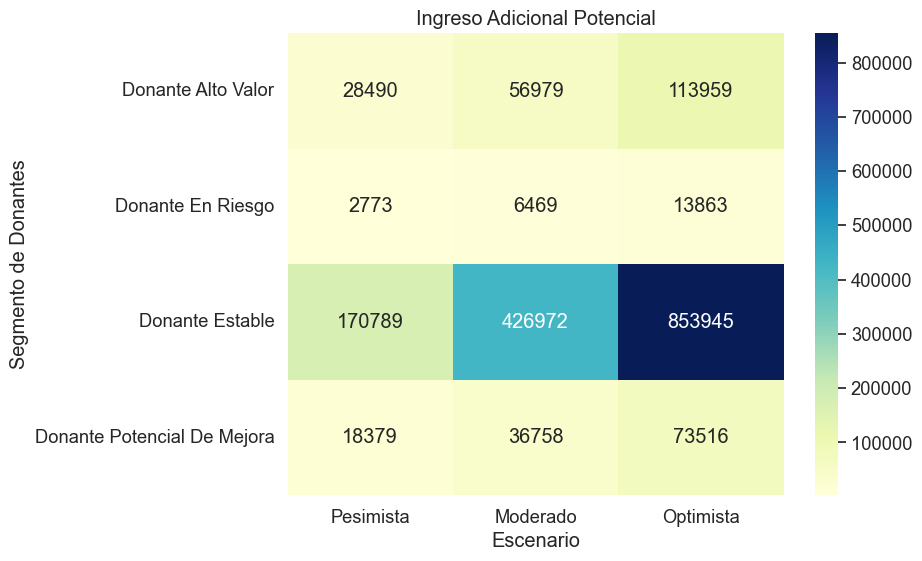

In [814]:
heatmap_data = df_resultados.pivot(index="Categoria", columns="Escenario", values="Ingreso Adicional Potencial").reindex(
    columns=["Pesimista", "Moderado", "Optimista"])

plt.figure(figsize=(8, 6))
ax = sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Ingreso Adicional Potencial")
plt.ylabel("Segmento de Donantes")
plt.xlabel("Escenario")
ax.set_yticklabels(new_y_labels)

plt.show()


- En el escenario optimista, el segmento de donante_estable genera un ingreso adicional potencial de aproximadamente 853.945, seguido de donante_alto_valor con 113.959 y donante_potencial_de_mejora con 73.516; en contraste, donante_en_riesgo aporta solo cerca de 13.863.

- Bajo el escenario moderado, los ingresos son 426.972, 56.979, 36.758 y 6.469 para donante_estable, donante_alto_valor, donante_potencial_de_mejora y donante_en_riesgo, respectivamente, mientras que en el escenario pesimista se estiman menores ingresos. 

- El mayor potencial de incremento se concentra en los segmentos estables y de alto valor, sugiriendo que la optimización de recursos en estos grupos podría maximizar significativamente los ingresos adicionales para la organización.

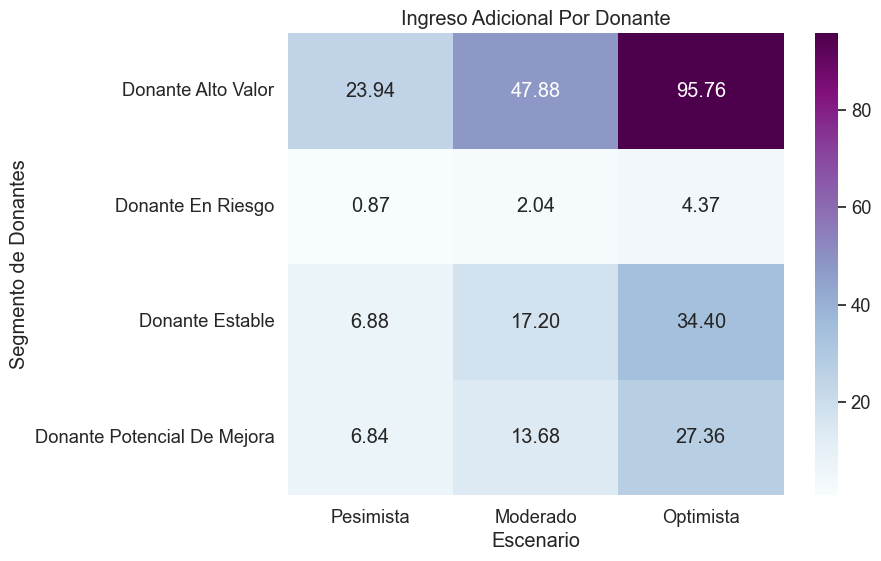

In [825]:
 # Visualización: Mapa de calor del ingreso adicional potencial por donante (métrica relativa)
heatmap_relativo = df_resultados.pivot(index="Categoria", columns="Escenario", values="Ingreso Adicional Por Donante").reindex(
    columns=["Pesimista", "Moderado", "Optimista"])

plt.figure(figsize=(8, 6))
ax = sns.heatmap(heatmap_relativo, annot=True, fmt=".2f", cmap="BuPu")
plt.title("Ingreso Adicional Por Donante")
plt.ylabel("Segmento de Donantes")
plt.xlabel("Escenario")
ax.set_yticklabels(new_y_labels)
plt.show()


- En el escenario optimista, cada donante de alto valor genera casi 96 soles adicionales en promedio, mientras que los donantes estables y potencial de mejora aportan alrededor de 34 y 27, respectivamente. 

- Por otro lado, los donantes en riesgo apenas suman 4,4 por donante. 

- Estos resultados indican que, en términos relativos, invertir en campañas dirigidas a donantes de alto valor y estables ofrece un mayor retorno por donante, mientras que los donantes en riesgo requieren estrategias diferenciadas para incrementar su aporte individual.

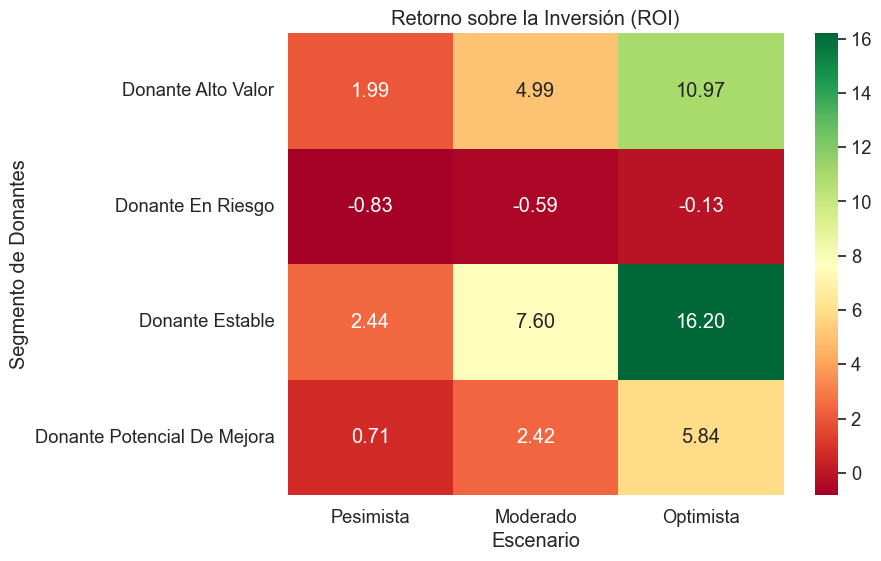

In [827]:
 
# Visualización: Mapa de calor del ROI por categoría y escenario
heatmap_roi = df_resultados.pivot(index="Categoria", columns="Escenario", values= "ROI").reindex(
    columns=["Pesimista", "Moderado", "Optimista"])
plt.figure(figsize=(8, 6))
ax = sns.heatmap(heatmap_roi, annot=True, fmt=".2f", cmap="RdYlGn")
plt.title("Retorno sobre la Inversión (ROI)")
plt.ylabel("Segmento de Donantes")
plt.xlabel("Escenario")
ax.set_yticklabels(new_y_labels)
plt.show()


** El ROI mide el retorno económico por cada sol invertido en la campaña. **

1. Los resultados indican que, bajo escenarios optimistas, por cada sol invertido en donante_alto_valor se obtienen casi 11 soles adicionales, y en donante_estable hasta 16 soles. 

2. Por el contrario, en donante_en_riesgo, incluso en un escenario optimista, la campaña apenas evita pérdidas, con un ROI cercano a -0.13, lo que indica que la inversión no se recupera. 

3. En donante_potencial_de_mejora, el retorno es positivo, pero moderado, con un máximo de casi 6 soles por soles invertido en el escenario optimista. 

Estos resultados sugieren focalizar los recursos en los segmentos de alto valor y estables, donde el impacto económico es significativamente mayor.

## Campañas Personalizadas Generadas con la API de OpenAI

In [745]:
# Seleccionar el 5% de cada categoría en una nueva DataFrame
df_sample = df_donantes_makting.groupby("categoria", group_keys=False).apply(lambda x: x.sample(frac=0.001))
df_sample["categoria"].value_counts()

categoria
donante_estable                25
donante_en_riesgo               3
donante_potencial_de_mejora     3
donante_alto_valor              1
Name: count, dtype: int64

In [693]:

api_key = "sk-proj-jO3ro1l4qmG03eGAJcYf461zpT0S-dij2XtVOqO9gdfsLeIQkvSeOWScasgaP6QKl_Kf3H3JPVNqrsT3BlbkFJnh814FDvAgHjj1p1wTmKyJYRUTfUGIu2wcKmhJr8TORwsuOhFnbV10DV5Ci7rdg94zWdx00z4A"                  
 

In [755]:
# ---------------------------------------------------------------------------
# API  llm

llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.9,
    max_tokens=400,  
    timeout=None,
    max_retries=2,
    api_key=api_key
)


# ---------------------------------------------------------------------------
# Prompt
systemPrompt = (
    """
    Eres un experto en marketing y comunicación especializado en campañas de donación para organizaciones sin fines de lucro.
    Tu tarea es generar mensajes ultra personalizados para incentivar la retención, el aumento de aportes y el compromiso de los donantes.
    La información del donante te ayudará a adaptar el mensaje y a seleccionar el medio de comunicación adecuado. 
    """
)



def build_user_prompt(donor_data: dict, estrategia: str) -> str:
    # Extraer solo el primer nombre en caso de múltiples nombres
    nombre_completo = donor_data.get("Nombre", "N/D")
    primer_nombre = nombre_completo.split()[0] if nombre_completo != "N/D" else "N/D"
    
    # Determinar el canal: Telemarketing o F2F (face-to-face)
    canal = donor_data.get("canal_de_la_campana", "").lower()
    if "telemarketing" in canal:
        firma = "\n\nCon gratitud y admiración,\nElvis Rojas\nAldeas Infantiles Perú"
    elif "f2f" in canal:
        firma = "\n\n¡Un cordial saludo de parte de Aldeas Infantiles Perú!"
    else:
        firma = ""  # En otros casos, no se incluye firma
    
    return (
        f"Genera un mensaje de campaña ultra personalizado para el siguiente donante utilizando solo la información proporcionada, "
        f"sin inventar datos. Asegúrate de que el mensaje esté completo y finalizado, sin cortes abruptos, y que contenga una conclusión clara.\n\n"
        f"Datos del donante:\n"
        f"- Nombre: {primer_nombre}\n"
        f"- Género: {donor_data.get('Género', 'N/D')}\n"
        f"- Categoría: {donor_data.get('categoria', 'N/D')}\n"
        f"- Medio de pago: {donor_data.get('medio_de_pago', 'N/D')}\n"
        f"- Antigüedad (meses): {donor_data.get('antiguedad', 'N/D')}\n"
        f"- Total donado: {donor_data.get('contacto_total_donado', 'N/D')}\n"
        f"- Cantidad de donaciones planificadas: {donor_data.get('cantidad_de_donaciones_planificadas', 'N/D')}\n"
        f"- Canal de campaña actual: {donor_data.get('canal_de_la_campana', 'N/D')}\n\n"
        f"Estrategia recomendada:\n{estrategia}\n\n"
        f"El mensaje debe invitar al donante a incrementar su aporte, reforzar su compromiso y destacar el impacto positivo de sus donaciones "
        f"en Aldeas Infantiles Perú. Utiliza un tono cordial, profesional y altamente personalizado, incluye emojis para hacerlo más entretenido "
        f"y amigable, y no cortes el mensaje, es decir, debe estar finalizado con una conclusión completa. "
        f"Si el mensaje es para Telemarketing, agrega la firma exacta al final: 'Con gratitud y admiración, Elvis Rojas, Aldeas Infantiles Perú'. "
        f"Si es para F2F, finaliza con: '¡Un cordial saludo de parte de Aldeas Infantiles Perú!'.\n\n"
        f"Termina el mensaje en 350 tokens o menos, pero asegúrate de que no se corte a la mitad ni falte información importante."
        f"{firma}"
    )


# ---------------------------------------------------------------------------
# Estrategia y medio de comunicación según la categoría
def obtener_estrategia(donor_data: dict) -> (str, str):
    categoria = donor_data.get("categoria", "")
    if categoria == "donante_alto_valor":
        medio = "Llamada telefónica + Email personalizado"
        estrategia = (
            "Objetivo: Incrementar el aporte y profundizar el compromiso. "
            "Se sugiere contactar de forma directa para invitar a eventos VIP y co-creación de proyectos."
        )
    elif categoria == "donante_estable":
        medio = "Email + SMS"
        estrategia = (
            "Objetivo: Retener al donante y aumentar el monto de sus donaciones. "
            "Se recomienda enviar reportes de impacto y ofertas escalonadas."
        )
    elif categoria == "donante_potencial_de_mejora":
        medio = "Email + Llamada de seguimiento"
        estrategia = (
            "Objetivo: Fomentar un mayor compromiso y crecimiento en el aporte. "
            "Proponer campañas consultivas que muestren oportunidades de impacto incremental."
        )
    elif categoria == "donante_en_riesgo":
        medio = "Llamada telefónica + Visita presencial"
        estrategia = (
            "Objetivo: Reactivar el compromiso y retener al donante en riesgo. "
            "Abordar inquietudes mediante contacto intensivo y visitas personalizadas."
        )
    else:
        medio      = "Email"
        estrategia = "Comunicación estándar de agradecimiento e información de impacto."
    return medio, estrategia

# ---------------------------------------------------------------------------
# Funciones auxiliares para generar email y teléfono aleatorios
def generar_email_aleatorio(nombre: str) -> str:
    # Convertir el nombre a minúsculas y eliminar espacios
    base = "".join(nombre.lower().split())
    numero = random.randint(100, 999)
    dominio = "ejemplo.com"
    return f"{base}{numero}@{dominio}"

def generar_telefono_peru() -> str:
    # Generar un número de 9 dígitos
    numero = ''.join(random.choices(string.digits, k=8))
    return f"+51 9{numero}"

# ---------------------------------------------------------------------------
# Definición del estado (para el grafo)
class State(TypedDict):
    aggregate: Annotated[list, operator.add]

# ---------------------------------------------------------------------------
# Clase de nodo para generar mensajes de campaña con el LLM y datos complementarios
class CampanaNode:
    def __init__(self, node_name: str, llm_model, system_prompt: str, donor_data: dict):
        self.node_name = node_name
        self.llm_model = llm_model
        self.system_prompt = system_prompt
        self.donor_data = donor_data
        
        # Obtener la estrategia y medio según la categoría del donante
        self.medio, self.estrategia = obtener_estrategia(donor_data)
        # Construir el prompt del usuario para el mensaje
        self.user_prompt = build_user_prompt(donor_data, self.estrategia)

    def __call__(self, state: State) -> Any:
        messages = [
            {"role": "system", "content": self.system_prompt},
            {"role": "user", "content": self.user_prompt}
        ]
        try:
            respuesta = self.llm_model.invoke(messages)
            mensaje_campana = respuesta.content.strip()
        except Exception as e:
            print(f"Error en el nodo {self.node_name}: {e}")
            mensaje_campana = "Error al generar mensaje"

        # Generar email y teléfono aleatorios para el donante
        nombre   = self.donor_data.get("Nombre", "N/D")
        email    = generar_email_aleatorio(nombre)
        telefono = generar_telefono_peru()

        # Retornar únicamente los datos relevantes para el equipo de marketing
        return {"aggregate": [{
            "Nombre": nombre,
            "Categoría": self.donor_data.get("categoria", "N/D"),
            "Email": email,
            "Teléfono": telefono,
            "Medio_Comunicación": self.medio,
            "Mensaje_Campaña": mensaje_campana,
            "Estrategia": self.estrategia,
            "Fecha_Envio_Propuesta": datetime.now().strftime("%Y-%m-%d")
        }]}



In [757]:
# ---------------------------------------------------------------------------
# Grafo de nodos para la campaña
builder = StateGraph(State)

# Para cada donante en la muestra, creamos un nodo que genera su mensaje de campaña personalizado
for idx, donor_row in df_sample.iterrows():
    node_name = f"nodo_{idx}"
    donor_data = donor_row.to_dict()
    nodo = CampanaNode(node_name, llm, systemPrompt, donor_data)
    builder.add_node(node_name, nodo)
    builder.add_edge(START, node_name)
    builder.add_edge(node_name, END)

graph = builder.compile()
config_run = RunnableConfig(recursion_limit=3)


In [759]:
# ---------------------------------------------------------------------------
# Ejecutar llm - grafo
start_time = time.time()
llm_response = graph.invoke({"aggregate": []}, config_run)
elapsed_time = time.time() - start_time

print(f"Tiempo de ejecución: {elapsed_time:.4f} segundos")
 

Tiempo de ejecución: 9.7406 segundos


In [834]:
df_campana_final = pd.DataFrame(llm_response["aggregate"])
print("DataFrame final de la campaña:\n")
df_campana_final.head(2)


DataFrame final de la campaña:



,Nombre,Categoría,Email,Teléfono,Medio_Comunicación,Mensaje_Campaña,Estrategia,Fecha_Envio_Propuesta
0,Betty Margot,donante_estable,bettymargot383@ejemplo.com,+51 924507189,Email + SMS,"Querida Betty, \n\nEs un honor contar contigo ...",Objetivo: Retener al donante y aumentar el mon...,2025-03-21
1,Aranxa Mariafe,donante_en_riesgo,aranxamariafe765@ejemplo.com,+51 991756260,Llamada telefónica + Visita presencial,"Querida Aranxa, \n\nQueremos expresarte nuestr...",Objetivo: Reactivar el compromiso y retener al...,2025-03-21


In [782]:
# Agrupar por "Categoría" y obtener el primer mensaje de cada grupo
df_ejemplo = df_campana_final.groupby("Categoría", as_index=False).first()

# Ejemplo de mensaje para cada categoría
for idx, row in df_ejemplo.iterrows():
    print(f"Mensaje {idx+1} (Categoría: {row['Categoría']}):")
    print("-" * 40)
    print(row["Mensaje_Campaña"] + "\n\n")
    print("-" * 40 )


Mensaje 1 (Categoría: donante_alto_valor):
----------------------------------------
Querida Gladys, como donante de alto valor de Aldeas Infantiles Perú, tu generosidad y compromiso durante 36 meses han transformado vidas 🌟. Tu aporte de 1190 soles en 40 donaciones ha marcado la diferencia. Te invitamos a seguir impactando juntos en eventos VIP y co-creación de proyectos exclusivos. Tu involucramiento es clave para construir un futuro brillante para los niños de Aldeas Infantiles Perú. ¡Contamos contigo para seguir haciendo la diferencia! 💖✨👧👦

Con gratitud y admiración,
Elvis Rojas
Aldeas Infantiles Perú


----------------------------------------
Mensaje 2 (Categoría: donante_en_riesgo):
----------------------------------------
Querida Aranxa, 

Queremos expresarte nuestra profunda gratitud por tu apoyo constante a lo largo de estos 33 meses. Tu compromiso con Aldeas Infantiles Perú ha sido invaluable. Sabemos que has estado considerando la continuidad de tu aporte, y queremos asegura

In [843]:
def estimate_tokens(text: str) -> int:
    """ Estimar costos asumiendo que un token es una palabra """
    if not text:
        return 0
    return len(text.split())


 
df_campana_final["Tokens"] = df_campana_final["Mensaje_Campaña"].apply(estimate_tokens) # tokens por cada mensaje  
num_mensajes = len(df_campana_final) # total de mensajes en la campaña actual
total_tokens = df_campana_final["Tokens"].sum() # tokens generados en la campaña actual

# Costo estimado por modelo (USD por 1,000 tokens)
cost_rates = {
    "GPT-3.5-turbo": 0.002,
    "GPT-4 (8k)": 0.045,
    "GPT-4-32k": 0.09,
    "text-davinci-003": 0.02
}


resultados = []
costo_por_token_proyeccion = df_donantes.shape[0]


for modelo, rate in cost_rates.items(): #para  cada modelo
    # Para la campana actual (32 mensajes) en subsample
    costo_por_token = rate / 1000  
    tokens_promedio = df_campana_final["Tokens"].mean()
    costo_promedio_mensaje = tokens_promedio * costo_por_token
    costo_total = total_tokens * costo_por_token
    
    # Proyección  (asuminedo que el promedio de tokens por mensaje se mantiene)
    tokens_proyeccion = tokens_promedio *  costo_por_token_proyeccion 
    costo_proyeccion = tokens_proyeccion * costo_por_token
    
    resultados.append({
        "Modelo": modelo,
        "Costo por Token ": round(costo_por_token, 6),
        "Tokens Promedio por Mensaje": round(tokens_promedio, 1),
        "Costo Promedio por Mensaje ": round(costo_promedio_mensaje, 6),
        f"Costo Total Actual ({num_mensajes} mensajes) ": round(costo_total, 6),
        f"Proyección para {costo_por_token_proyeccion} Mensajes ": round(costo_proyeccion, 6)
    })

 
df_costos = pd.DataFrame(resultados)
print("Tabla comparativa de costos (USD):\n\n")
df_costos


Tabla comparativa de costos (USD):




,Modelo,Costo por Token,Tokens Promedio por Mensaje,Costo Promedio por Mensaje,Costo Total Actual (32 mensajes),Proyección para 31877 Mensajes
0,GPT-3.5-turbo,0.000002,174.5,0.000349,0.011166,11.123081
1,GPT-4 (8k),0.000045,174.5,0.007851,0.251235,250.269315
2,GPT-4-32k,0.000090,174.5,0.015702,0.502470,500.538631
3,text-davinci-003,0.000020,174.5,0.003489,0.111660,111.230807
